# Fortegra Data Challenge 

A new potential partner is coming to us with a potential portfolio for us to work with. The portfolio is insurance for irrigation sprinklers, a type of farming equipment. They have been running this program for about 5 years and are looking for a new partner to work with them. We have an opportunity to analyze their data and recommend underwriting changes to improve the performance of their portfolio. We are targeting a loss rate of 60% or lower for any portfolio we work with. Loss ratio is defined as sum of total claims paid / sum of total premium earned, over a given time period.
There are 2 datasets attached: claims.csv has one row per claim filed and premiums.csv has one row per piece of equipment.
1. Clean the data how you see fit. State your assumptions. Assume that a cleaned subset of the data is better than data which is skewed, biased, or incorrect. Include conceptual validations/cleaning.
2. Calculate loss ratio by state, county, customer’s number of previous claims, deductible amount, and equipment year. Explain your results and note anything you found interesting or important.
3. Perform other pieces of EDA/analysis you think is interesting. Since time is limited, you can limit to 1-2 analyses, then list other analysis you think would be interesting to look at if you had more time.
4. Based on the analysis you’ve done, what are some recommended changes to the underwriting of this portfolio?


In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Generic Libraries
import numpy as np
import pandas as pd
from scipy import stats
from scipy.optimize import curve_fit
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [3]:
claims_data = '../data/claims.csv'
premiums_data = '../data/premiums.csv'

In [4]:
claims_df = pd.read_csv(claims_data)
premiums_df = pd.read_csv(premiums_data)

# Data Sanity Checks
## Claims Dataframe

#### Check for null or NaN values

In [5]:
claims_df.isna().sum()

PolicyNumber            0
CustomerId              0
DateOfLoss              0
ClaimReceivedDate       2
ClaimCause              0
TotalPaidToDate         0
Deductible              0
County                 31
State                  31
EquipmentYear          33
PolicyEffectiveDate     0
dtype: int64

In [6]:
claims_df[claims_df.isna().any(axis = 1)].head(10)

,PolicyNumber,CustomerId,DateOfLoss,ClaimReceivedDate,ClaimCause,TotalPaidToDate,Deductible,County,State,EquipmentYear,PolicyEffectiveDate
44,P-4875-2022,4254,2022-09-05,2022-10-17,Claim Denied,626.50,2500,NaN,NaN,NaN,2022-05-02
140,P-1206-2022,4706,2022-07-05,2022-07-07,Claim Denied,0.00,2500,NaN,NaN,NaN,2022-07-05
335,P-538-2022,3691,2022-05-05,2022-05-09,Claim Withdrawn,0.00,1000,NaN,NaN,NaN,2021-06-01
408,P-2668-2022,2170,2022-04-22,2022-05-11,Claim Denied,0.00,1000,NaN,NaN,NaN,2021-07-30
441,P-4732-2022,510,2022-02-23,2022-05-18,Claim Denied,0.00,1000,NaN,NaN,NaN,2022-02-23
592,P-38-2021,2340,2021-08-19,2021-12-10,Collision-Irr,19224.88,2500,NaN,NaN,NaN,2021-05-15
756,P-5308-2021,967,2021-06-11,2021-06-21,Collision-Irr,50000.00,2500,NaN,NaN,NaN,2020-08-07
813,P-5057-2021,5192,2021-04-01,2021-04-15,Claim Denied,0.00,1000,NaN,NaN,NaN,2020-07-22
827,P-2486-2021,4191,2021-03-15,2021-03-18,Claim Withdrawn,0.00,5000,NaN,NaN,NaN,2020-04-01
843,P-3871-2021,4499,2021-02-22,2021-03-10,Claim Withdrawn,0.00,1000,NaN,NaN,NaN,2021-02-03


#### - It appears that missing information may be linked to "Claim Withdrawn" and "Claim Denied" status in the ClaimCause field.
#### - Additionally, County, State, and EquipmentYear appear to usually be missing concurrently.
#### - The ClaimRecievedDate is missing twice; this may be due to some clerical error.

### Explore Unique Values

In [7]:
claims_df.nunique()

PolicyNumber           2056
CustomerId             1555
DateOfLoss              931
ClaimReceivedDate       831
ClaimCause               16
TotalPaidToDate        2186
Deductible                5
County                  249
State                    20
EquipmentYear            55
PolicyEffectiveDate    1082
dtype: int64

#### - PolicyNumber count is greater than the number of Customers. This is likely due to customers having multiple policies.
#### - This observation holds true for the premiums dataframe as well.

### Feature Breakdown

#### Low-Cardinality Ordinal
1. EquipmentYear
2. Deductible

#### High-Cardinality Ordinal
1. PolicyEffectiveDate
2. ClaimReceivedDate
3. DateOfLoss

#### Low-Cardinality Categorical
1. State
2. ClaimCause

#### High-Cardinality Categorical
1. County
2. CustomerId
3. PolicyNumber

#### Continuous
1. TotalPaidToDate

# Data Sanity Checks
## Premiums Dataframe

#### Check for null or NaN values

In [8]:
premiums_df.isna().sum()

PolicyNumber             0
CustomerId               0
Loc                      0
PolicyEffectiveDate      0
PolicyExpirationDate     0
PolicyPremium            0
LocationPremium          0
Deductible               0
LocValue                 0
County                   0
State                    0
Equip Year              83
Equip Value             83
dtype: int64

In [9]:
premiums_df[premiums_df.isna().any(axis = 1)].head(10)

,PolicyNumber,CustomerId,Loc,PolicyEffectiveDate,PolicyExpirationDate,PolicyPremium,LocationPremium,Deductible,LocValue,County,State,Equip Year,Equip Value
5359,P-1031-2022,1278,5,2022-06-01,2023-06-01,40634,2209.107960,1000,163935.90,Edwards,KS,NaN,NaN
5378,P-1031-2022,1278,14,2022-06-01,2023-06-01,40634,2309.700103,1000,147693.00,Edwards,KS,NaN,NaN
8622,P-1860-2019,4671,2,2019-05-06,2020-05-06,2248,358.949932,1000,22954.25,Crosby,TX,NaN,NaN
8624,P-1860-2019,4671,3,2019-05-06,2020-05-06,2248,154.125395,1000,9869.25,Hale,TX,NaN,NaN
8627,P-1860-2020,4671,2,2020-05-06,2021-05-06,2248,367.000000,1000,22954.25,Crosby,TX,NaN,NaN
8629,P-1860-2020,4671,3,2020-05-06,2021-05-06,2248,158.000000,1000,9869.25,Hale,TX,NaN,NaN
9279,P-1042-2018,3246,5,2018-03-26,2019-03-26,5392,557.000000,1000,33743.59,Clay,SD,NaN,NaN
14549,P-3697-2018,1589,6,2018-09-02,2019-09-02,8737,1285.000000,1000,80341.18,Tom Green,TX,NaN,NaN
14558,P-3697-2019,1589,6,2019-09-02,2020-09-02,12615,1380.067683,1000,80341.18,Tom Green,TX,NaN,NaN
14570,P-3697-2020,1589,6,2020-09-02,2021-09-02,12615,1285.000000,1000,80341.18,Tom Green,TX,NaN,NaN


#### - Equipment Year and Equipment Value are typically missing, concurrently.

### Explore Unique Values

In [10]:
premiums_df.nunique()

PolicyNumber            17522
CustomerId               5307
Loc                       126
PolicyEffectiveDate      1995
PolicyExpirationDate     1995
PolicyPremium            6318
LocationPremium         25934
Deductible                  5
LocValue                 3944
County                    383
State                      28
Equip Year                 63
Equip Value              3915
dtype: int64

#### - While it appears that LocValue and Equip Value are the same, LocValue has more distinct values, suggesting there are some differences.

### Feature Breakdown

#### Low-Cardinality Ordinal
1. Equip Year
2. Deductible
3. Loc

#### High-Cardinality Ordinal
1. PolicyExpirationDate
2. PolicyEffectiveDate

#### Low-Cardinality Categorical
1. State

#### High-Cardinality Categorical
1. County
2. CustomerId
3. PolicyNumber

#### Continuous
1. Equip Value
2. LocValue
3. LocationPremium
4. PolicyPremium

# Hypothesis:
### Claim Denied and Claim Withdrawn are linked to NULL values in County/State/Equipment Year

In [11]:
def set_hypothesis_value(
    row : any
) -> int:
    if row['ClaimCause'] == 'Claim Withdrawn' or row['ClaimCause'] == 'Claim Denied':
        return 1
    else:
        return 0

In [12]:
hypothesis_df = claims_df.copy()[['ClaimCause', 'County', 'State', 'EquipmentYear']]
hypothesis_df['hypothesisFlag'] = hypothesis_df.apply(set_hypothesis_value, axis = 1)

In [13]:
hypothesis_df.loc[hypothesis_df['hypothesisFlag'] == 1].head(5)

,ClaimCause,County,State,EquipmentYear,hypothesisFlag
2,Claim Withdrawn,Edwards,KS,0.0,1
6,Claim Denied,Sherman,KS,2001.0,1
15,Claim Withdrawn,Fillmore,NE,1976.0,1
44,Claim Denied,NaN,NaN,NaN,1
64,Claim Withdrawn,Garden,NE,2000.0,1


In [14]:
def set_null_value(
    row : any
) -> int:
    if pd.isna(row['County']) or pd.isna(row['State']) or pd.isna(row['EquipmentYear']):
        return 1
    else:
        return 0

In [15]:
hypothesis_df['nullFlag'] = hypothesis_df.apply(set_null_value, axis = 1)

In [16]:
hypothesis_df.loc[hypothesis_df['hypothesisFlag'] == 1].head(5)

,ClaimCause,County,State,EquipmentYear,hypothesisFlag,nullFlag
2,Claim Withdrawn,Edwards,KS,0.0,1,0
6,Claim Denied,Sherman,KS,2001.0,1,0
15,Claim Withdrawn,Fillmore,NE,1976.0,1,0
44,Claim Denied,NaN,NaN,NaN,1,1
64,Claim Withdrawn,Garden,NE,2000.0,1,0


In [17]:
from scipy.stats import chi2_contingency

In [18]:
contingency_table = pd.crosstab(hypothesis_df['nullFlag'], hypothesis_df['hypothesisFlag'])

chi2, p_value, _, _ = chi2_contingency(contingency_table)

alpha = 0.05
if p_value < alpha:
    print(fr'The binary features are correlated with a p-value of: {p_value}')
else:
    print(fr'The binary features are NOT correlated with a p-value of: {p_value}')

The binary features are correlated with a p-value of: 1.250353815000371e-44


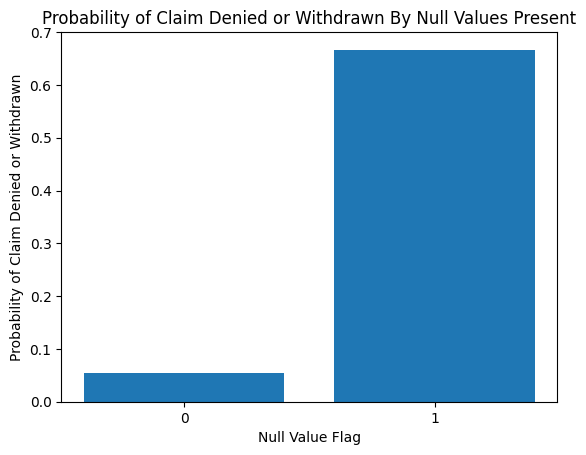

In [19]:
mean_by_nullFlag = hypothesis_df.groupby('nullFlag')['hypothesisFlag'].mean()

plt.bar(mean_by_nullFlag.index.astype(str), mean_by_nullFlag)
plt.xlabel('Null Value Flag')
plt.ylabel('Probability of Claim Denied or Withdrawn')
plt.title('Probability of Claim Denied or Withdrawn By Null Values Present')
plt.show()

### - The hypothesis is true: if a NULL value is present, the claim is MUCH more likely to be denied or withdrawn.
### - Based on the objective of the overall analysis, we can probably drop claims denied and claims withdrawn from the dataset. As a result, this should mostly reduce all of the NULL values.

# Dropping 'Claims Denied' and 'Claims Withdrawn'

In [20]:
claims_df['ClaimCause'].unique()

array(['Lightning-Irr', 'Claim Withdrawn', 'Collision-Irr', 'M&E-Irr',
       'Claim Denied', 'Wind-Irr', 'Collapse-Irr', 'Fire-Irr', 'Hail-Irr',
       'Theft-Irr', 'Flood-Irr', 'Vandalism-Irr', 'Animal-Irr',
       'Overturn-Irr', 'Freezing-Irr', 'Vand-Irr'], dtype=object)

In [21]:
claims_df = claims_df[~claims_df['ClaimCause'].isin(['Claim Denied', 'Claim Withdrawn'])]

### Check for presence of NULL values again

In [22]:
claims_df.isna().sum()

PolicyNumber            0
CustomerId              0
DateOfLoss              0
ClaimReceivedDate       2
ClaimCause              0
TotalPaidToDate         0
Deductible              0
County                  9
State                   9
EquipmentYear          11
PolicyEffectiveDate     0
dtype: int64

#### - Some NULL values are still present; however, NULL values may be important from a modeling perspective.
#### - Nevertheless, for the sake of Exploratory Data Analysis (EDA), we will drop NULL values.
#### - When doing modeling, we will retain NULL values (XGBoost or imputation techniques)

# Dropping NULL Values

In [23]:
claims_df = claims_df.dropna()
claims_df.isna().sum()

PolicyNumber           0
CustomerId             0
DateOfLoss             0
ClaimReceivedDate      0
ClaimCause             0
TotalPaidToDate        0
Deductible             0
County                 0
State                  0
EquipmentYear          0
PolicyEffectiveDate    0
dtype: int64

In [24]:
claims_df.head(5)

,PolicyNumber,CustomerId,DateOfLoss,ClaimReceivedDate,ClaimCause,TotalPaidToDate,Deductible,County,State,EquipmentYear,PolicyEffectiveDate
0,P-654-2022,419,2022-12-23,2023-01-03,Lightning-Irr,10466.75,1000,Chase,NE,1993.0,2022-11-20
1,P-3199-2022,2667,2022-12-19,2023-02-08,Lightning-Irr,4535.69,1000,Tattnall,GA,0.0,2022-03-19
3,P-4890-2022,2794,2022-12-02,2022-12-08,Collision-Irr,20347.48,1000,Pawnee,KS,2022.0,2022-10-01
4,P-4102-2022,1233,2022-11-22,2022-11-29,Collision-Irr,15458.86,1000,Floyd,TX,0.0,2022-04-08
5,P-3968-2022,3700,2022-11-04,2022-11-14,M&E-Irr,8511.76,1000,Cochran,TX,2016.0,2022-02-23


In [25]:
premiums_df = premiums_df.dropna()
premiums_df.isna().sum()

PolicyNumber            0
CustomerId              0
Loc                     0
PolicyEffectiveDate     0
PolicyExpirationDate    0
PolicyPremium           0
LocationPremium         0
Deductible              0
LocValue                0
County                  0
State                   0
Equip Year              0
Equip Value             0
dtype: int64

In [26]:
premiums_df.head(5)

,PolicyNumber,CustomerId,Loc,PolicyEffectiveDate,PolicyExpirationDate,PolicyPremium,LocationPremium,Deductible,LocValue,County,State,Equip Year,Equip Value
0,P-562-2018,3833,1,2018-03-01,2019-03-01,594,594.0,1000,36000.0,Furnas,NE,1994.0,36000.0
1,P-5085-2018,3123,1,2018-08-10,2019-08-10,7520,960.0,1000,60000.0,Castro,TX,1993.0,60000.0
2,P-5085-2018,3123,2,2018-08-10,2019-08-10,7520,1760.0,1000,110000.0,Castro,TX,2015.0,110000.0
3,P-5085-2018,3123,3,2018-08-10,2019-08-10,7520,960.0,1000,60000.0,Castro,TX,1988.0,60000.0
4,P-5085-2018,3123,4,2018-08-10,2019-08-10,7520,1760.0,1000,110000.0,Castro,TX,2014.0,110000.0


# Datatype Check

In [27]:
claims_df.dtypes

PolicyNumber            object
CustomerId               int64
DateOfLoss              object
ClaimReceivedDate       object
ClaimCause              object
TotalPaidToDate        float64
Deductible               int64
County                  object
State                   object
EquipmentYear          float64
PolicyEffectiveDate     object
dtype: object

In [28]:
claims_df['DateOfLoss'] = pd.to_datetime(claims_df['DateOfLoss'])
claims_df['ClaimReceivedDate'] = pd.to_datetime(claims_df['ClaimReceivedDate'])
claims_df['PolicyEffectiveDate'] = pd.to_datetime(claims_df['PolicyEffectiveDate'])

claims_df = claims_df.astype({
    'PolicyNumber': 'string',
    'ClaimCause': 'string',
    'County': 'string',
    'State': 'string'
})

In [29]:
claims_df.dtypes

PolicyNumber           string[python]
CustomerId                      int64
DateOfLoss             datetime64[ns]
ClaimReceivedDate      datetime64[ns]
ClaimCause             string[python]
TotalPaidToDate               float64
Deductible                      int64
County                 string[python]
State                  string[python]
EquipmentYear                 float64
PolicyEffectiveDate    datetime64[ns]
dtype: object

In [30]:
premiums_df['PolicyEffectiveDate'] = pd.to_datetime(premiums_df['PolicyEffectiveDate'])
premiums_df['PolicyExpirationDate'] = pd.to_datetime(premiums_df['PolicyExpirationDate'])

premiums_df = premiums_df.astype({
    'PolicyNumber': 'string',
    'County': 'string',
    'State': 'string'
})

In [31]:
premiums_df.dtypes

PolicyNumber            string[python]
CustomerId                       int64
Loc                              int64
PolicyEffectiveDate     datetime64[ns]
PolicyExpirationDate    datetime64[ns]
PolicyPremium                    int64
LocationPremium                float64
Deductible                       int64
LocValue                       float64
County                  string[python]
State                   string[python]
Equip Year                     float64
Equip Value                    float64
dtype: object

## Check for Duplicate Rows

In [32]:
claims_df.duplicated().sum()

0

In [33]:
premiums_df.duplicated().sum()

2237

In [34]:
premiums_df = premiums_df.drop_duplicates()

In [35]:
premiums_df.duplicated().sum()

0

#### **Discussion**: The premiums dataframe had 2,237 duplicate rows. These must be removed from the analysis.

# Feature Assumptions

In [169]:
claims_df.head(1)

,PolicyNumber,CustomerId,DateOfLoss,ClaimReceivedDate,ClaimCause,TotalPaidToDate,Deductible,County,State,EquipmentYear,PolicyEffectiveDate
0,P-654-2022,419,2022-12-23,2023-01-03,Lightning-Irr,10466.75,1000,Chase,NE,1993.0,2022-11-20


## Claims Dataframe: This represents an individual claim.
1. **PolicyNumber**: This represents the ID of a unique policy.
2. **CustomerId**: This represents the ID of a unique customer.
3. **DateOfLoss**: This represents when the accident occurred which resulted in a claim.
4. **ClaimReceivedDate**: This represents the time in which the customer made a claim regarding the incident.
5. **ClaimCause**: This represents the customers' reason for the cause of the incident.
6. **TotalPaidToDate**: This represents the amount we paid out to the customer for the given claim.
7. **Deductible**: This represents the deductible that the customer paid on the claim.
8. **County**: The county in which the incident occurred.
9. **State**: The state in which the incident occurred.
10. **EquipmentYear**: The year in which the equipment was made.
11. **PolicyEffectiveDate**: The time in which the policy started which was eligible for a claim.

In [170]:
premiums_df.head(1)

,PolicyNumber,CustomerId,Loc,PolicyEffectiveDate,PolicyExpirationDate,PolicyPremium,LocationPremium,Deductible,LocValue,County,State,Equip Year,Equip Value
0,P-562-2018,3833,1,2018-03-01,2019-03-01,1188.0,594.0,1000,36000.0,Furnas,NE,1994.0,36000.0


## Premiums Dataframe: This represents a policy on an individual piece of equipment.
1. **PolicyNumber**: This represents the ID of a unique policy.
2. **CustomerId**: This represents the ID of a unique customer.
3. **DateOfLoss**: This represents when the accident occurred which resulted in a claim.
4. **ClaimReceivedDate**: This represents the time in which the customer made a claim regarding the incident.
5. **ClaimCause**: This represents the customers' reason for the cause of the incident.
6. **TotalPaidToDate**: This represents the amount we paid out to the customer for the given claim.
7. **Deductible**: This represents the deductible that the customer paid on the claim.
8. **County**: The county in which the incident occurred.
9. **State**: The state in which the incident occurred.
10. **EquipmentYear**: The year in which the equipment was made.
11. **PolicyEffectiveDate**: The time in which the policy started which was eligible for a claim.

# Univariate Analysis

## Continuous Features: PolicyPremium, LocationPremium, Equip Value, TotalPaidToDate

#### PolicyPremium

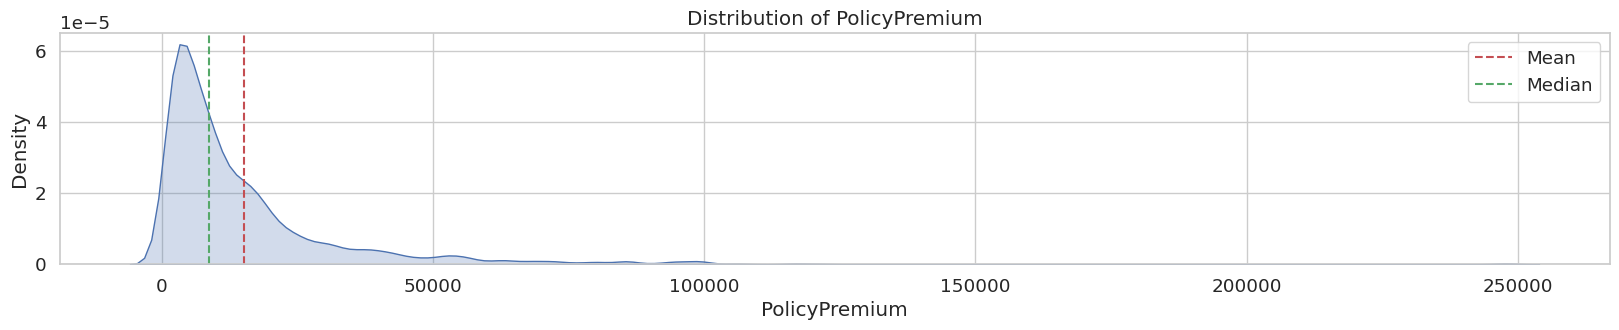

In [36]:
plt.figure(figsize=(20, 3))

sns.set(style = 'whitegrid', font_scale = 1.2)
sns.kdeplot(data = premiums_df['PolicyPremium'], color = 'b', fill = True)

plt.xlabel('PolicyPremium')
plt.ylabel('Density')
plt.title('Distribution of PolicyPremium')

mean = premiums_df['PolicyPremium'].mean()
plt.axvline(mean, color='r', linestyle='--', label='Mean')
plt.legend()

median = premiums_df['PolicyPremium'].median()
plt.axvline(median, color = 'g', linestyle = '--', label = 'Median')
plt.legend()

plt.show()

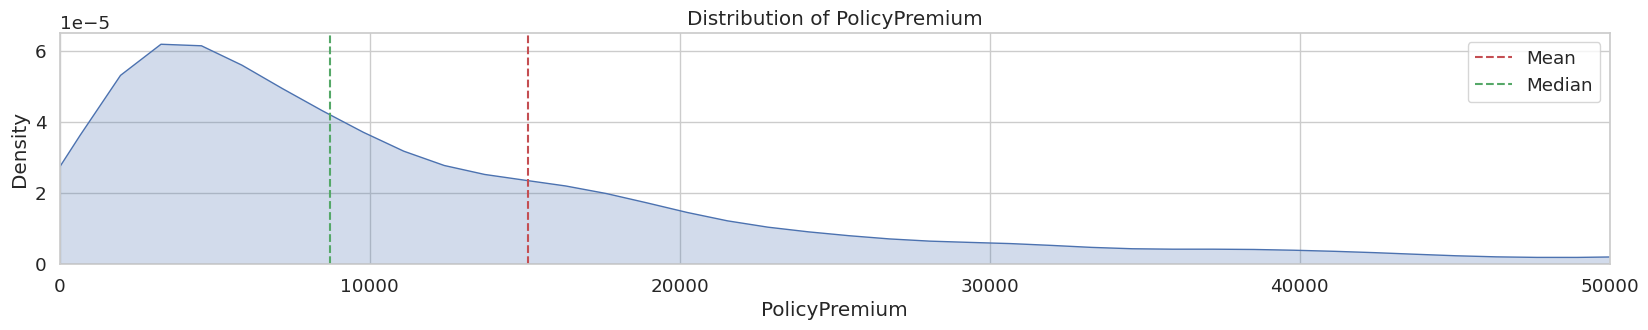

In [37]:
plt.figure(figsize=(20, 3))

sns.set(style = 'whitegrid', font_scale = 1.2)
ax = sns.kdeplot(data = premiums_df['PolicyPremium'], color = 'b', fill = True)

ax.set_xlim([0, 50000])

plt.xlabel('PolicyPremium')
plt.ylabel('Density')
plt.title('Distribution of PolicyPremium')

mean = premiums_df['PolicyPremium'].mean()
plt.axvline(mean, color = 'r', linestyle = '--', label = 'Mean')
plt.legend()

median = premiums_df['PolicyPremium'].median()
plt.axvline(median, color = 'g', linestyle = '--', label = 'Median')
plt.legend()

plt.show()

#### **Discussion**: The PolicyPremium field is a right-skewed (positive skew) distribution. The peak of the distribution is nested somewhere around $4000.

### LocationPremium

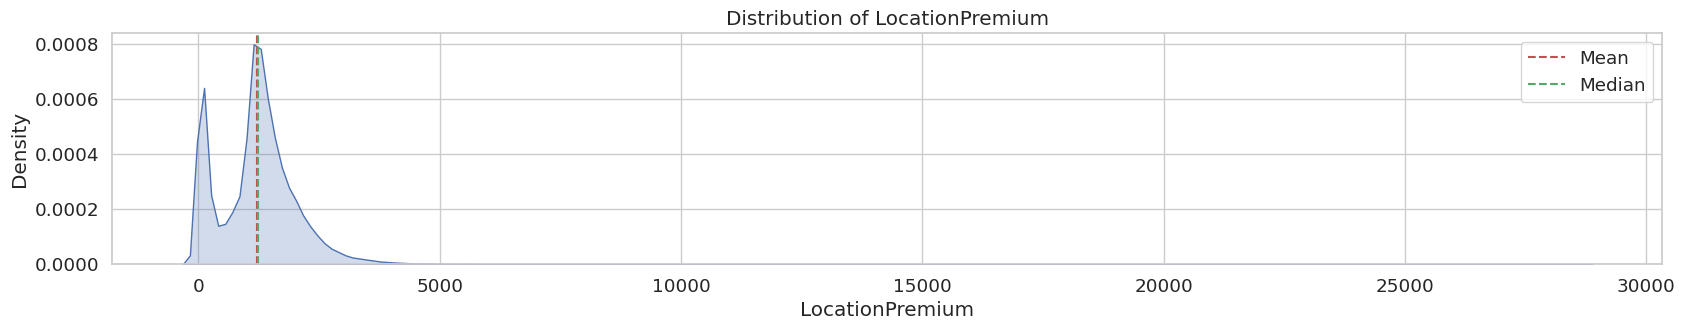

In [38]:
plt.figure(figsize=(20, 3))

sns.set(style = 'whitegrid', font_scale = 1.2)
sns.kdeplot(data = premiums_df['LocationPremium'], color = 'b', fill = True)

plt.xlabel('LocationPremium')
plt.ylabel('Density')
plt.title('Distribution of LocationPremium')

mean = premiums_df['LocationPremium'].mean()
plt.axvline(mean, color='r', linestyle='--', label='Mean')
plt.legend()

median = premiums_df['LocationPremium'].median()
plt.axvline(median, color = 'g', linestyle = '--', label = 'Median')
plt.legend()

plt.show()

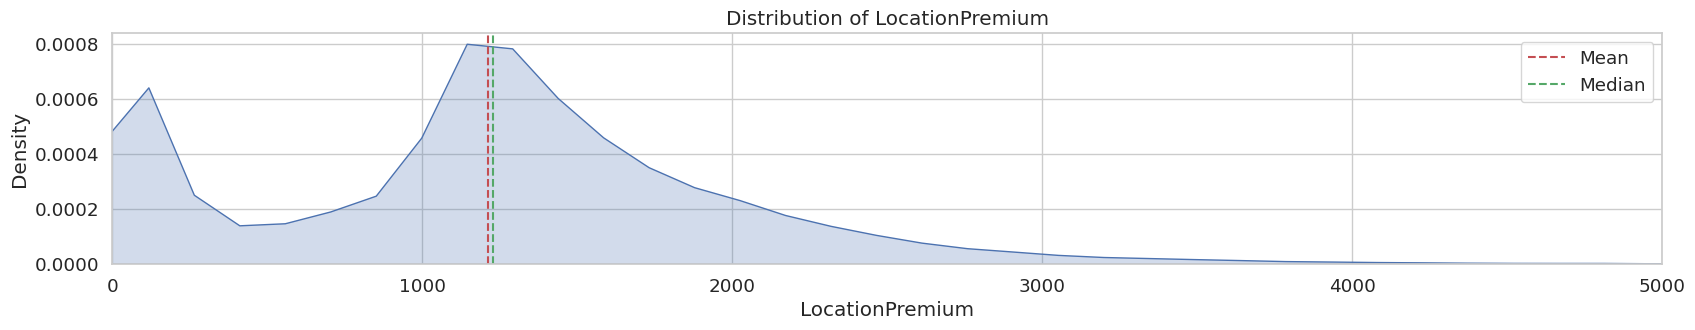

In [39]:
plt.figure(figsize=(20, 3))

sns.set(style = 'whitegrid', font_scale = 1.2)
ax = sns.kdeplot(data = premiums_df['LocationPremium'], color = 'b', fill = True)

ax.set_xlim([0, 5000])

plt.xlabel('LocationPremium')
plt.ylabel('Density')
plt.title('Distribution of LocationPremium')

mean = premiums_df['LocationPremium'].mean()
plt.axvline(mean, color = 'r', linestyle = '--', label = 'Mean')
plt.legend()

median = premiums_df['LocationPremium'].median()
plt.axvline(median, color = 'g', linestyle = '--', label = 'Median')
plt.legend()

plt.show()

#### **Discussion**: LocationPremium is a bi-modal distribution. This may require additional feature engineering. It is also right-skewed.
#### One peak of the distribution appear to be around \$1,000.
#### The other peak is $12,000.

### Equip Value

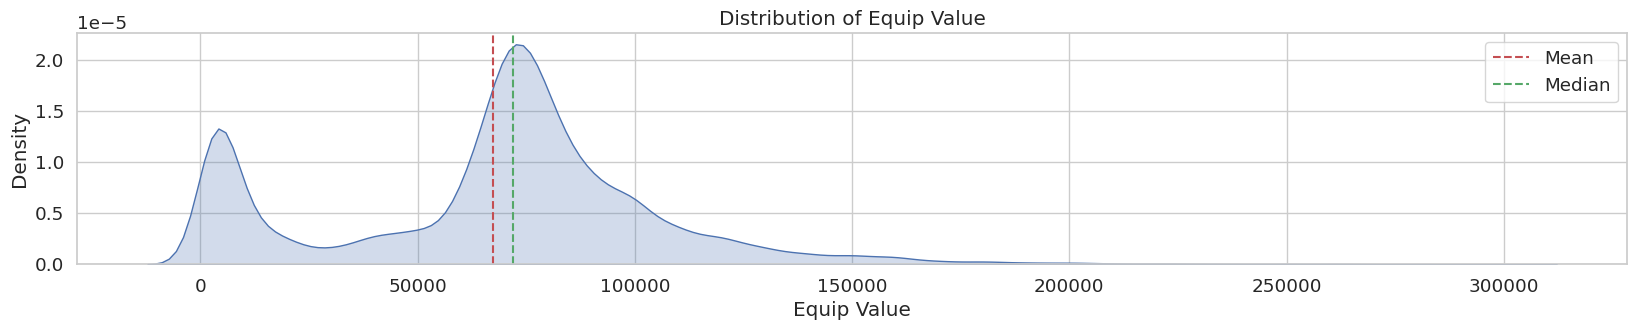

In [40]:
plt.figure(figsize=(20, 3))

sns.set(style = 'whitegrid', font_scale = 1.2)
sns.kdeplot(data = premiums_df['Equip Value'], color = 'b', fill = True)

plt.xlabel('Equip Value')
plt.ylabel('Density')
plt.title('Distribution of Equip Value')

mean = premiums_df['Equip Value'].mean()
plt.axvline(mean, color='r', linestyle='--', label='Mean')
plt.legend()

median = premiums_df['Equip Value'].median()
plt.axvline(median, color = 'g', linestyle = '--', label = 'Median')
plt.legend()

plt.show()

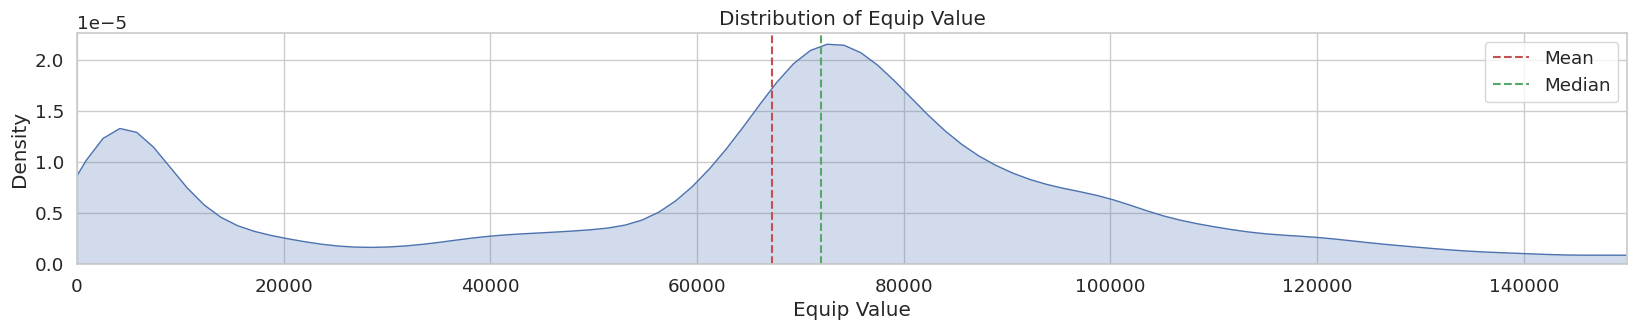

In [41]:
plt.figure(figsize=(20, 3))

sns.set(style = 'whitegrid', font_scale = 1.2)
ax = sns.kdeplot(data = premiums_df['Equip Value'], color = 'b', fill = True)

ax.set_xlim([0, 150000])

plt.xlabel('Equip Value')
plt.ylabel('Density')
plt.title('Distribution of Equip Value')

mean = premiums_df['Equip Value'].mean()
plt.axvline(mean, color = 'r', linestyle = '--', label = 'Mean')
plt.legend()

median = premiums_df['Equip Value'].median()
plt.axvline(median, color = 'g', linestyle = '--', label = 'Median')
plt.legend()

plt.show()

#### **Discussion**: Equip Value is another bi-modal distribution with right-skewness.
#### The first peak appears to be at \$4,000.
#### The other peak appears to be at \$75,000.

### TotalPaidToDate

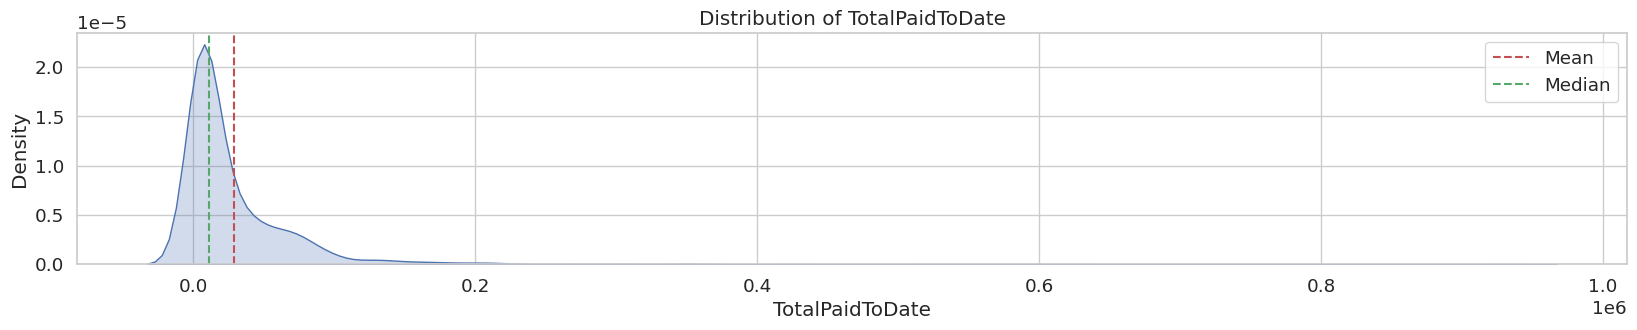

In [42]:
plt.figure(figsize=(20, 3))

sns.set(style = 'whitegrid', font_scale = 1.2)
sns.kdeplot(data = claims_df['TotalPaidToDate'], color = 'b', fill = True)

plt.xlabel('TotalPaidToDate')
plt.ylabel('Density')
plt.title('Distribution of TotalPaidToDate')

mean = claims_df['TotalPaidToDate'].mean()
plt.axvline(mean, color='r', linestyle='--', label='Mean')
plt.legend()

median = claims_df['TotalPaidToDate'].median()
plt.axvline(median, color = 'g', linestyle = '--', label = 'Median')
plt.legend()

plt.show()

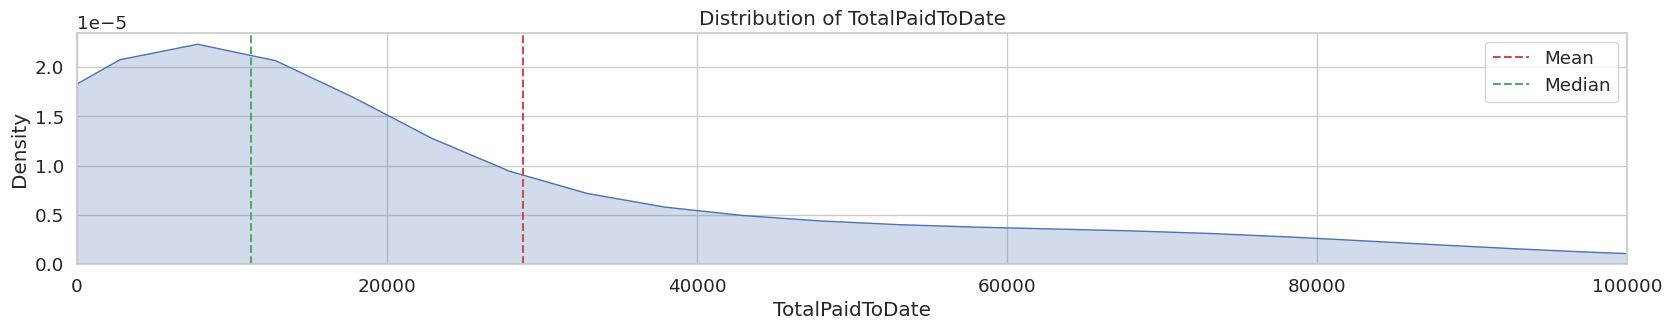

In [43]:
plt.figure(figsize=(20, 3))

sns.set(style = 'whitegrid', font_scale = 1.2)
ax = sns.kdeplot(data = claims_df['TotalPaidToDate'], color = 'b', fill = True)

ax.set_xlim([0, 100000])

plt.xlabel('TotalPaidToDate')
plt.ylabel('Density')
plt.title('Distribution of TotalPaidToDate')

mean = claims_df['TotalPaidToDate'].mean()
plt.axvline(mean, color = 'r', linestyle = '--', label = 'Mean')
plt.legend()

median = claims_df['TotalPaidToDate'].median()
plt.axvline(median, color = 'g', linestyle = '--', label = 'Median')
plt.legend()

plt.show()

#### **Discussion**: The TotalPaidToDate feature is right-skewed. The peak of the distribution appears to be at \$9,000.

## Low-Cardinality Ordinal Features: Equip Year, Deductible

### Equip Year

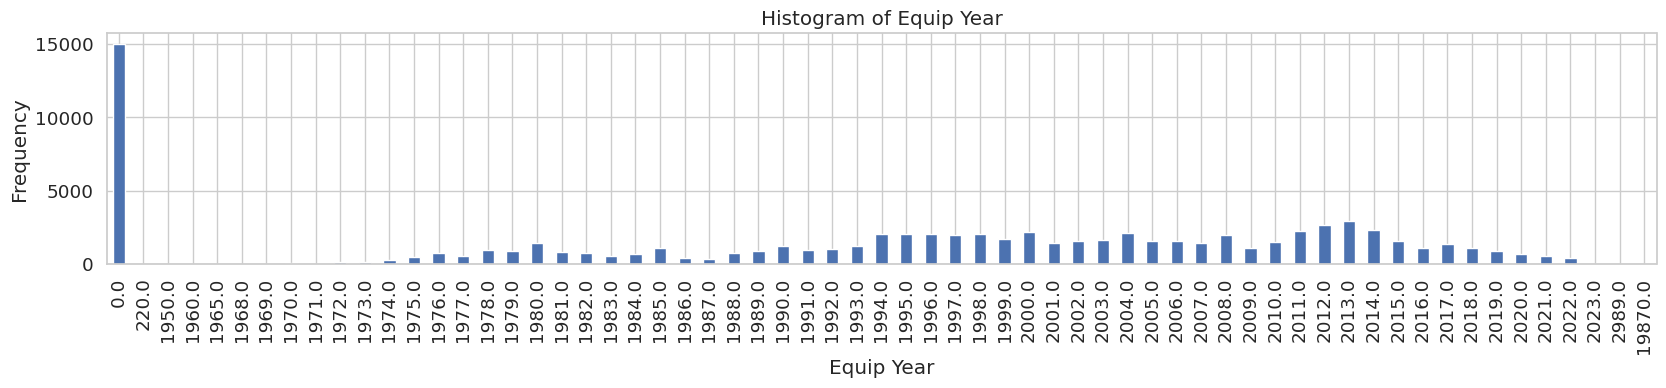

In [44]:
value_counts = premiums_df['Equip Year'].value_counts().sort_index()

plt.figure(figsize = (20, 3))
value_counts.plot(kind = 'bar')
plt.xlabel('Equip Year')
plt.ylabel('Frequency')
plt.title('Histogram of Equip Year')
plt.show()

In [45]:
premiums_df.loc[premiums_df['Equip Year'] == 0.0].head(2)

,PolicyNumber,CustomerId,Loc,PolicyEffectiveDate,PolicyExpirationDate,PolicyPremium,LocationPremium,Deductible,LocValue,County,State,Equip Year,Equip Value
174,P-1195-2020,3222,2,2020-05-29,2021-05-29,5016,143.152835,1000,5000.0,Fillmore,NE,0.0,5000.0
175,P-1195-2020,3222,2,2020-05-29,2021-05-29,5016,431.342095,1000,15000.0,Fillmore,NE,0.0,15000.0


In [46]:
premiums_df.loc[premiums_df['Equip Year'] == 220.0].head(2)

,PolicyNumber,CustomerId,Loc,PolicyEffectiveDate,PolicyExpirationDate,PolicyPremium,LocationPremium,Deductible,LocValue,County,State,Equip Year,Equip Value
9452,P-4604-2019,4916,41,2019-12-06,2020-12-06,45152,0.000000,1000,66000.0,Hamilton,NE,220.0,66000.0
71599,P-3065-2019,1784,5,2019-05-18,2020-05-18,4881,357.649601,1000,110000.0,Bent,CO,220.0,110000.0


In [47]:
premiums_df.loc[premiums_df['Equip Year'] == 2989.0].head(2)

,PolicyNumber,CustomerId,Loc,PolicyEffectiveDate,PolicyExpirationDate,PolicyPremium,LocationPremium,Deductible,LocValue,County,State,Equip Year,Equip Value
19886,P-2669-2018,3023,1,2018-09-23,2019-09-23,1188,1188.0,1000,72000.0,Clay,NE,2989.0,72000.0
19887,P-2669-2019,3023,1,2019-09-23,2020-09-23,1188,1188.0,1000,72000.0,Clay,NE,2989.0,72000.0


In [48]:
premiums_df.loc[premiums_df['Equip Year'] == 19870.0].head(2)

,PolicyNumber,CustomerId,Loc,PolicyEffectiveDate,PolicyExpirationDate,PolicyPremium,LocationPremium,Deductible,LocValue,County,State,Equip Year,Equip Value
80142,P-3664-2017,1165,15,2017-09-08,2018-09-08,32960,2080.0,1000,130000.0,Dallam,TX,19870.0,130000.0


#### **Discussion**: Based on this analysis of Equip Year, it can be assumed that values of 0.0 represent NULL.
#### Additionally, outlandish values should be imputed to be 0.0.
#### **Proposition**: Any values outside the range of 1950 - PRESENT should be imputed to 0.0.

In [49]:
from datetime import datetime

def impute_zero_for_year(
    value : float
) -> float:
    current_year = datetime.now().year
    if 1950.0 <= value <= current_year:
        return value
    else:
        return 0.0

In [50]:
premiums_df['Equip Year'] = premiums_df['Equip Year'].apply(impute_zero_for_year)

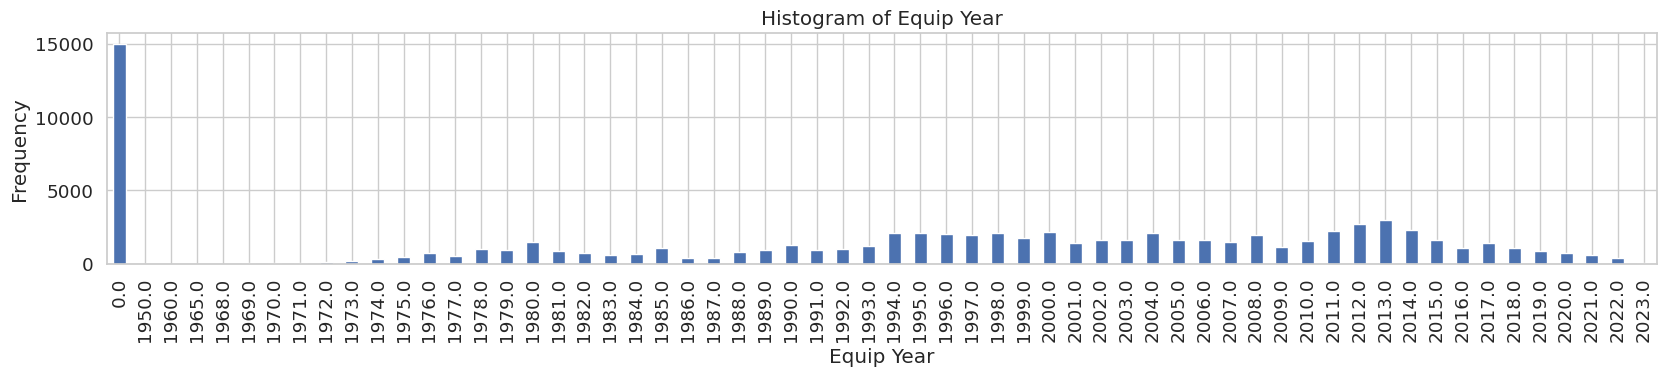

In [51]:
value_counts = premiums_df['Equip Year'].value_counts().sort_index()

plt.figure(figsize = (20, 3))
value_counts.plot(kind = 'bar')
plt.xlabel('Equip Year')
plt.ylabel('Frequency')
plt.title('Histogram of Equip Year')
plt.show()

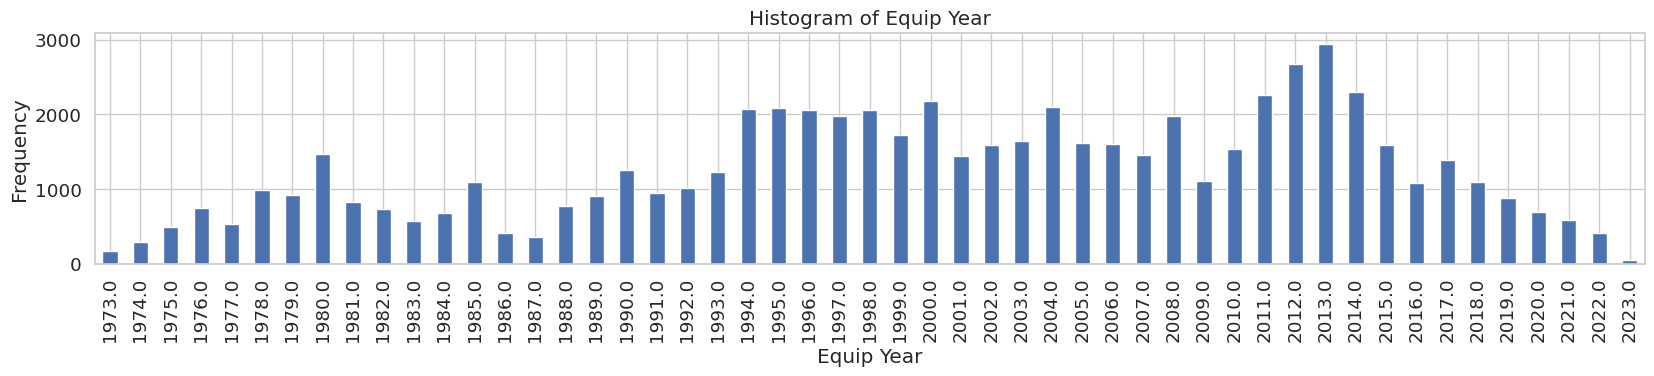

In [52]:
filtered_df = premiums_df[(premiums_df['Equip Year'] >= 1973) & (premiums_df['Equip Year'] <= 2023)]

value_counts = filtered_df['Equip Year'].value_counts().sort_index()

plt.figure(figsize = (20, 3))
value_counts.plot(kind = 'bar')
plt.xlabel('Equip Year')
plt.ylabel('Frequency')
plt.title('Histogram of Equip Year')
plt.show()

#### **Discussion**: There appears to be a drop in equipment insurance in the past 10 years.
#### I suspect this means that our customers tend to insure equipment once it has been owned for 10 years.
#### Perhaps internal processes mark equipment insurance policies from equipment in recent years as possible fraud or deny those policies on the front-end until that equipment has aged.

#### **Further Discussion**:
#### Reasons to deny policies on recent equipment:
1. **Lack of Maintenance Records:** If the equipment doesn't have a well-documented maintenance record, insurers might be hesitant to offer a policy. Regular maintenance helps keep equipment in good condition and reduces the likelihood of unexpected breakdowns.
2. **High-Risk Equipment:** The type of equipment can also be a factor. If the equipment is deemed high-risk due to the nature of its use or the industry it's used in, an insurer may deny a policy.
3. **Lack of Operating History:** Newer equipment may not have enough operating history for the insurer to make an informed risk assessment.
4. **High Repair/Replacement Costs:** If the equipment is particularly expensive to repair or replace, the insurer may consider it to be a high risk. This is particularly true for certain types of modern equipment that require specialized parts or labor.
5. **High Frequency of Claims:** If the insurer's historical data shows a high frequency of claims for that type of equipment or in that industry within the first five years, they may deny coverage.
6. **Insurance Fraud:** The insurer might suspect insurance fraud if the application for insurance has inconsistencies, if the owner has a history of insurance fraud, or if the claim rate for the type of equipment is unusually high.

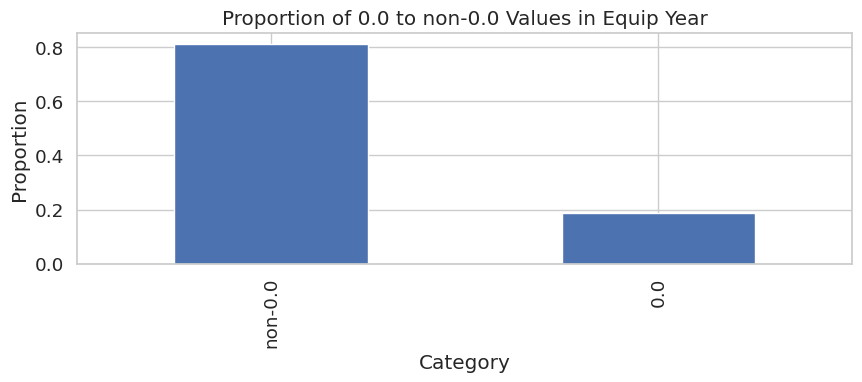

In [53]:
proportions_df = premiums_df.copy()
proportions_df['Category'] = ['0.0' if x == 0.0 else 'non-0.0' for x in proportions_df['Equip Year']]

category_counts = proportions_df['Category'].value_counts()

proportions = category_counts / len(proportions_df)

plt.figure(figsize = (10, 3))
proportions.plot(kind = 'bar')
plt.ylabel('Proportion')
plt.title('Proportion of 0.0 to non-0.0 Values in Equip Year')
plt.show()

#### **Discussion**: Imputed 0.0 values only make up 20% of the total values in Equip Year. This means that the equipment year is known 80% of the time.

### Deductible

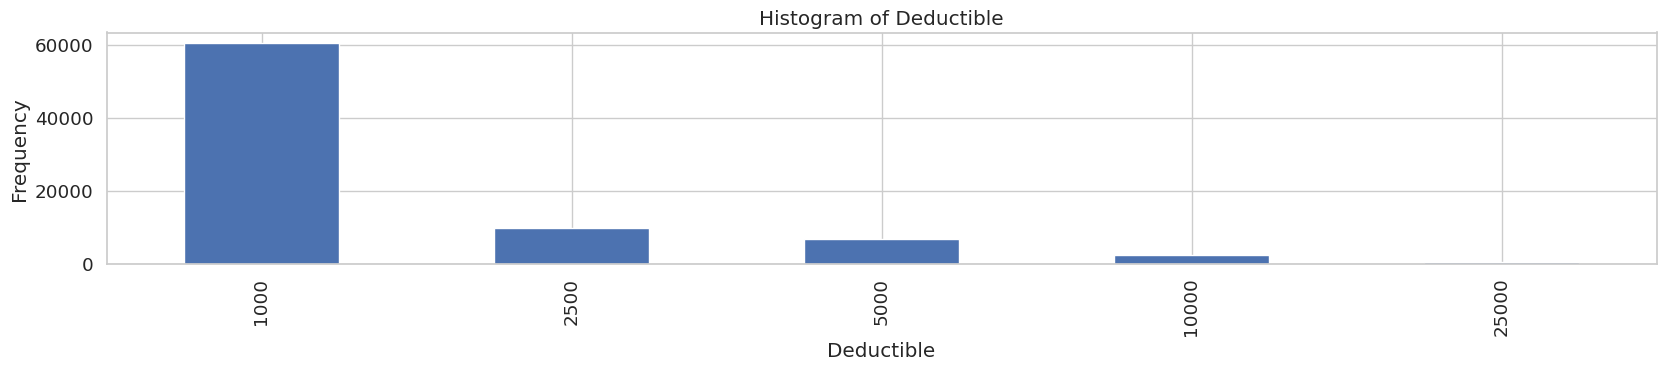

In [54]:
value_counts = premiums_df['Deductible'].value_counts().sort_index()

plt.figure(figsize = (20, 3))
value_counts.plot(kind = 'bar')
plt.xlabel('Deductible')
plt.ylabel('Frequency')
plt.title('Histogram of Deductible')
plt.show()

#### **Discussion**: The majority of deductibles are 1000. This is relevant towards underwriting practices and may be subject to change.

## Low-Cardinality Categorical: State, ClaimCause

### State

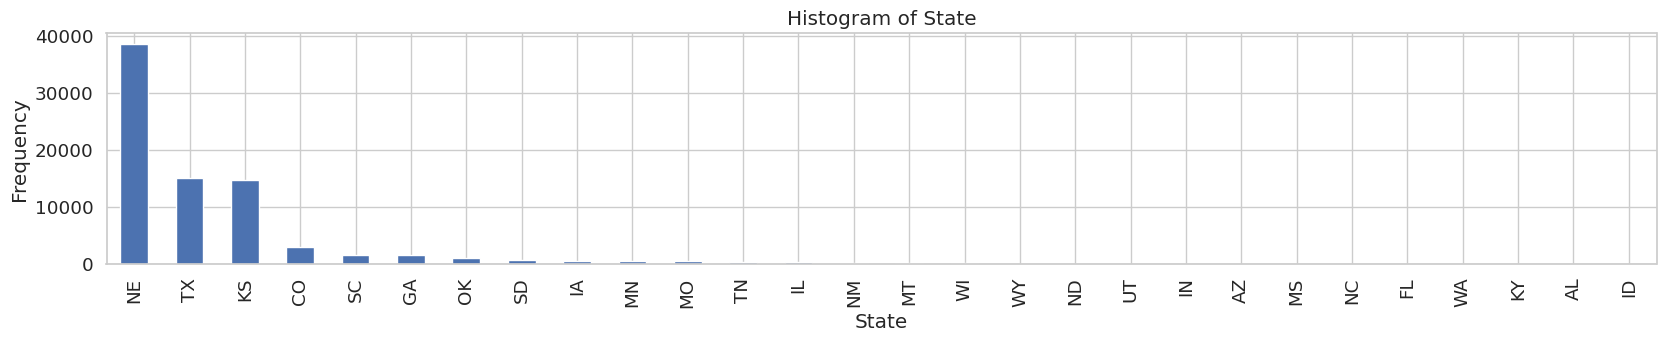

In [55]:
value_counts = premiums_df['State'].value_counts()

plt.figure(figsize = (20, 3))
value_counts.plot(kind = 'bar')
plt.xlabel('State')
plt.ylabel('Frequency')
plt.title('Histogram of State')
plt.show()

#### **Discussion**: The majority of equipment can be found in Nebraska, Texas, and Kansas.
#### This makes some sense, because Texas, Kansas, and Nebraska lead the US states in terms of farmland.
#### However, it should be noted that Texas has 2.5 times as much farmland as Nebraska, yet it has approximately 2.5 times less equipment represented in our sample.
#### This means that Texas has approximately 6 times less policies with Fortegra as expected.
#### **This may represent an opportunity for Fortegra to expand into the Texas market.**

### ClaimCause

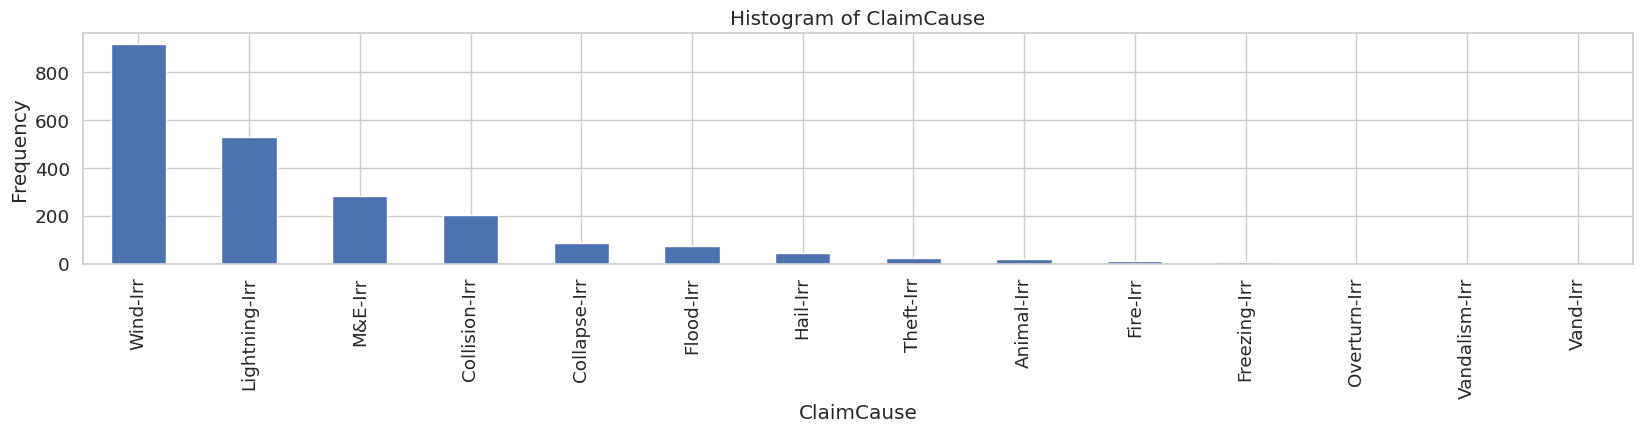

In [56]:
value_counts = claims_df['ClaimCause'].value_counts()

plt.figure(figsize = (20, 3))
value_counts.plot(kind = 'bar')
plt.xlabel('ClaimCause')
plt.ylabel('Frequency')
plt.title('Histogram of ClaimCause')
plt.show()

#### **Discussion**: Wind, Lightning, Accidents, and Collisions represent the majority of claims.

## High-Cardinality Categorical: County

### County

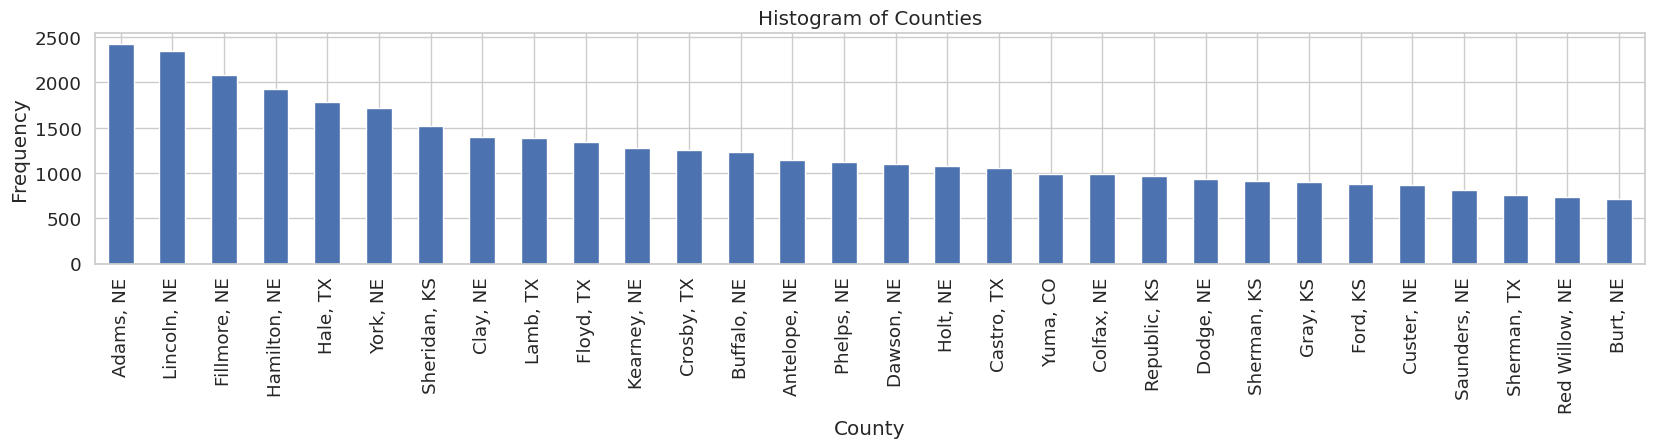

In [57]:
combined_county_state_df = premiums_df.copy()
combined_county_state_df['County_State'] = combined_county_state_df['County'] + ', ' + combined_county_state_df['State']

value_counts = combined_county_state_df['County_State'].value_counts()[:30]

plt.figure(figsize = (20, 3))
value_counts.plot(kind = 'bar')
plt.xlabel('County')
plt.ylabel('Frequency')
plt.title('Histogram of Counties')
plt.show()

#### **Discussion**: The top 4 counties are in Nebraska. Additionally, the histogram shows a monotonic decrease by county.

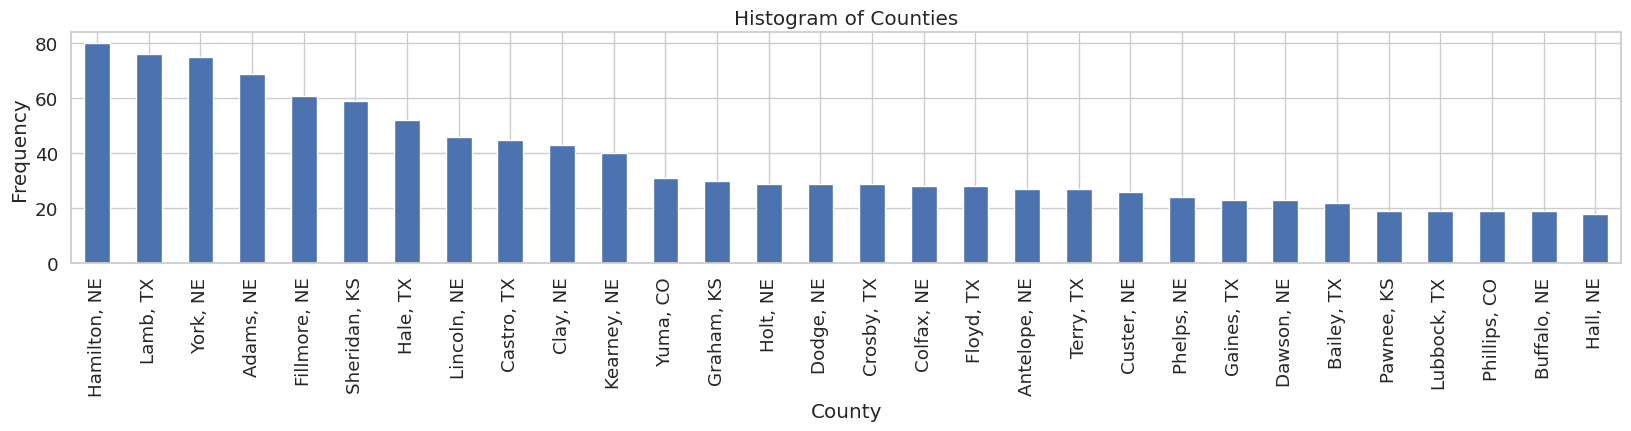

In [58]:
combined_county_state_df = claims_df.copy()
combined_county_state_df['County_State'] = combined_county_state_df['County'] + ', ' + combined_county_state_df['State']

value_counts = combined_county_state_df['County_State'].value_counts()[:30]

plt.figure(figsize = (20, 3))
value_counts.plot(kind = 'bar')
plt.xlabel('County')
plt.ylabel('Frequency')
plt.title('Histogram of Counties')
plt.show()

#### **Discussion**: For claims, the counties with the highest number of claims roughly matches to the counties with the highest number of policies. This also shows a monotonic decrease per county.

# Assumption: PolicyPremium should be wrapped with LocationPremium

In [59]:
premiums_df['PolicyPremium'] = premiums_df['PolicyPremium'] + premiums_df['LocationPremium']

# Calculate Loss Ratios
## Calculate loss ratio by state, county, customer’s number of previous claims, deductible amount, and equipment year. Explain your results and note anything you found interesting or important.

In [60]:
claims_df['PolicyNumber'].count()

2219

In [61]:
if claims_df['PolicyNumber'].nunique() == claims_df['PolicyNumber'].count():
    print('The column is unique.')
else:
    print('The column is not unique.')

The column is not unique.


In [62]:
claims_df.loc[claims_df['PolicyNumber'].duplicated()][['PolicyNumber']].head(2)

,PolicyNumber
46,P-5265-2022
55,P-188-2022


In [63]:
claims_df.head(1)

,PolicyNumber,CustomerId,DateOfLoss,ClaimReceivedDate,ClaimCause,TotalPaidToDate,Deductible,County,State,EquipmentYear,PolicyEffectiveDate
0,P-654-2022,419,2022-12-23,2023-01-03,Lightning-Irr,10466.75,1000,Chase,NE,1993.0,2022-11-20


#### **Discussion**: The rows in the claims dataframe represent a row per claim filed.

In [64]:
premiums_df.head(1)

,PolicyNumber,CustomerId,Loc,PolicyEffectiveDate,PolicyExpirationDate,PolicyPremium,LocationPremium,Deductible,LocValue,County,State,Equip Year,Equip Value
0,P-562-2018,3833,1,2018-03-01,2019-03-01,1188.0,594.0,1000,36000.0,Furnas,NE,1994.0,36000.0


#### **Discussion**: The rows in then premiums dataframe represent a row per equipment.

### Loss ratio by state
#### **Procedure**: Sum the claims amount per state; sum then premiums amount per state. Calculate the loss ratio.

In [65]:
claims_agg_df = claims_df[['State', 'TotalPaidToDate']].groupby('State').sum().reset_index()

In [66]:
claims_agg_df.head(2)

,State,TotalPaidToDate
0,AL,22603.66
1,AZ,179306.16


In [67]:
premiums_agg_df = premiums_df[['State', 'PolicyPremium']].groupby('State').sum().reset_index()

In [68]:
premiums_agg_df.head(2)

,State,PolicyPremium
0,AL,17966.0
1,AZ,1092590.0


In [69]:
state_loss_ratio_df = pd.merge(claims_agg_df, premiums_agg_df, on = 'State', how = 'inner')

In [70]:
state_loss_ratio_df.head(2)

,State,TotalPaidToDate,PolicyPremium
0,AL,22603.66,17966.0
1,AZ,179306.16,1092590.0


In [71]:
state_loss_ratio_df['loss_ratio'] = state_loss_ratio_df['TotalPaidToDate'] / state_loss_ratio_df['PolicyPremium']

In [72]:
state_loss_ratio_df

,State,TotalPaidToDate,PolicyPremium,loss_ratio
0,AL,22603.66,1.796600e+04,1.258135
1,AZ,179306.16,1.092590e+06,0.164111
2,CO,1337740.56,3.050886e+07,0.043848
3,GA,470756.94,4.007126e+07,0.011748
4,IA,437482.76,6.041270e+06,0.072416
5,IL,223925.82,2.947281e+06,0.075977
6,IN,23748.46,3.320000e+05,0.071532
7,KS,10304662.84,2.870093e+08,0.035904
8,MN,2034853.72,6.859640e+06,0.296641
9,MO,508338.09,6.232927e+06,0.081557


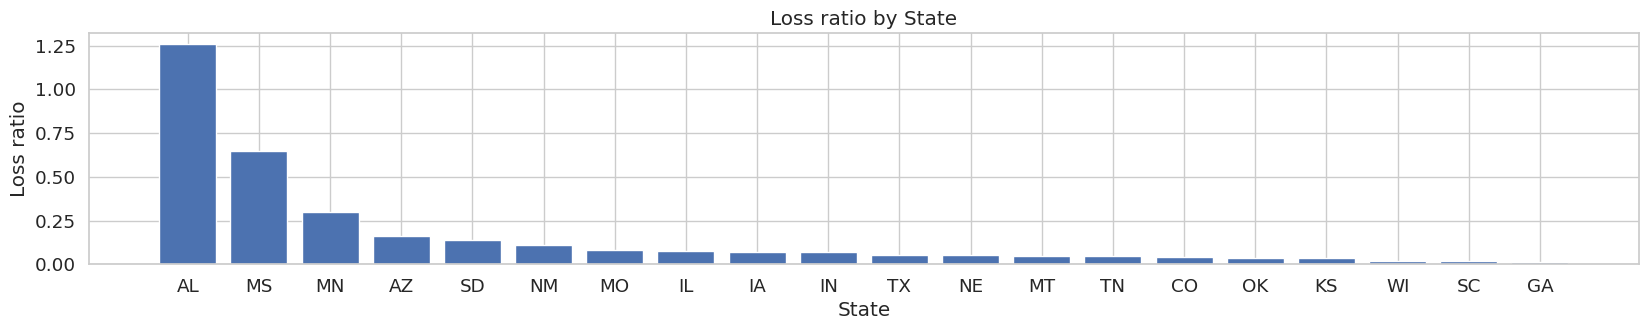

In [73]:
state_loss_ratio_df = state_loss_ratio_df.sort_values('loss_ratio', ascending = False)

plt.figure(figsize = (20, 3))

plt.bar(state_loss_ratio_df['State'], state_loss_ratio_df['loss_ratio'])

plt.title('Loss ratio by State')
plt.xlabel('State')
plt.ylabel('Loss ratio')

plt.show()

In [74]:
state_loss_ratio_df.loc[state_loss_ratio_df['State'] == 'AL']

,State,TotalPaidToDate,PolicyPremium,loss_ratio
0,AL,22603.66,17966.0,1.258135


In [75]:
state_loss_ratio_df.loc[state_loss_ratio_df['State'] == 'MS']

,State,TotalPaidToDate,PolicyPremium,loss_ratio
10,MS,210180.45,323657.0,0.649393


#### **Discussion**: Based on the results of the loss ratio per state, it appears that Alabama represents a statistical outlier.
#### The policy premium and total paid to date are relatively low, so this suggests there was an outlier accident which occurred.
#### There is a small chance this was a fraudulent claim as well. Additional analysis would be needed to make such a claim.

#### **Discussion**: While Alabama has a low claim amount and policy premium, Mississippi has significant amounts in both categories.
#### We may need to dig deeper into why the loss ratio is so high; it could be the case that Alabama and Mississippi were involved in
#### some natural catastrophe (black swan event). If that is the case, then a majority of their claims may occur on the same or similar dates.

#### **Hypothesis**: Check to see if Mississippi and Alabama have claims on or around the same date.

In [76]:
MS_AL_claims_df = claims_df.loc[claims_df['State'].isin(['MS', 'AL'])][['State', 'ClaimCause', 'ClaimReceivedDate', 'TotalPaidToDate']].copy()

In [77]:
MS_AL_claims_df.sort_values('State')

,State,ClaimCause,ClaimReceivedDate,TotalPaidToDate
947,AL,Lightning-Irr,2020-09-21,22603.66
789,MS,Wind-Irr,2021-05-06,94786.50
857,MS,Wind-Irr,2021-03-09,37733.91
1448,MS,M&E-Irr,2019-08-14,21612.18
2342,MS,Wind-Irr,2018-03-29,56047.86


#### **Discussion**: Alabama's loss ratio is due to a single, outlier incident.
#### Mississippi's loss ratio is due to unrelated accident, mostly due to wind.
#### Both states have high loss ratios primarely due to chance, so we do not have enough evidence to suggest underwriting changes.

#### **Proposition**: Earlier it was mentioned that Texas is a "growth area" for Fortegra; it represents a market that we can grow into.
#### It is seen above that our loss ratio for Texas is 0.056498, which is well below our established threshold of 0.6.
#### Because of this, it may be beneficial to reduce our premiums (increase the loss ratio) in Texas such that we can be more competitive in that market.
#### For instance, since we stand to grow 6 times the current customer base in the Texas, if we could - hypothetically - achieve that level of growth,
#### we should proportionally be able to time on 6 times the loss ratio of our current loss ratio for Texas (0.056 * 6 = 0.336).

### Loss ratio by county
#### **Procedure**: Sum the claims amount per county; sum then premiums amount per county. Calculate the loss ratio.

In [78]:
claims_combined_county_state_df = claims_df.copy()
claims_combined_county_state_df['County'] = claims_combined_county_state_df['County'] + ', ' + claims_combined_county_state_df['State']

premiums_combined_county_state_df = premiums_df.copy()
premiums_combined_county_state_df['County'] = premiums_combined_county_state_df['County'] + ', ' + premiums_combined_county_state_df['State']

In [79]:
claims_agg_df = claims_combined_county_state_df[['County', 'TotalPaidToDate']].groupby('County').sum().reset_index()

In [80]:
premiums_agg_df = premiums_combined_county_state_df[['County', 'PolicyPremium']].groupby('County').sum().reset_index()

In [81]:
county_loss_ratio_df = pd.merge(claims_agg_df, premiums_agg_df, on = 'County', how = 'inner')

In [82]:
county_loss_ratio_df['loss_ratio'] = county_loss_ratio_df['TotalPaidToDate'] / county_loss_ratio_df['PolicyPremium']

In [83]:
county_loss_ratio_df.head(10)

,County,TotalPaidToDate,PolicyPremium,loss_ratio
0,"Adams, CO",2704.52,7.330500e+04,0.036894
1,"Adams, NE",1845990.07,2.748456e+07,0.067165
2,"Andrews, TX",4981.14,1.174520e+05,0.042410
3,"Antelope, NE",712114.88,1.957800e+07,0.036373
4,"Armstrong, TX",79100.00,1.388410e+05,0.569716
5,"Arthur, NE",57898.33,1.729019e+06,0.033486
6,"Atchison, MO",158000.00,9.788100e+04,1.614205
7,"Baca, CO",291316.89,1.200692e+06,0.242624
8,"Bailey, TX",246283.18,2.668088e+06,0.092307
9,"Barton, KS",100217.79,7.801691e+05,0.128456


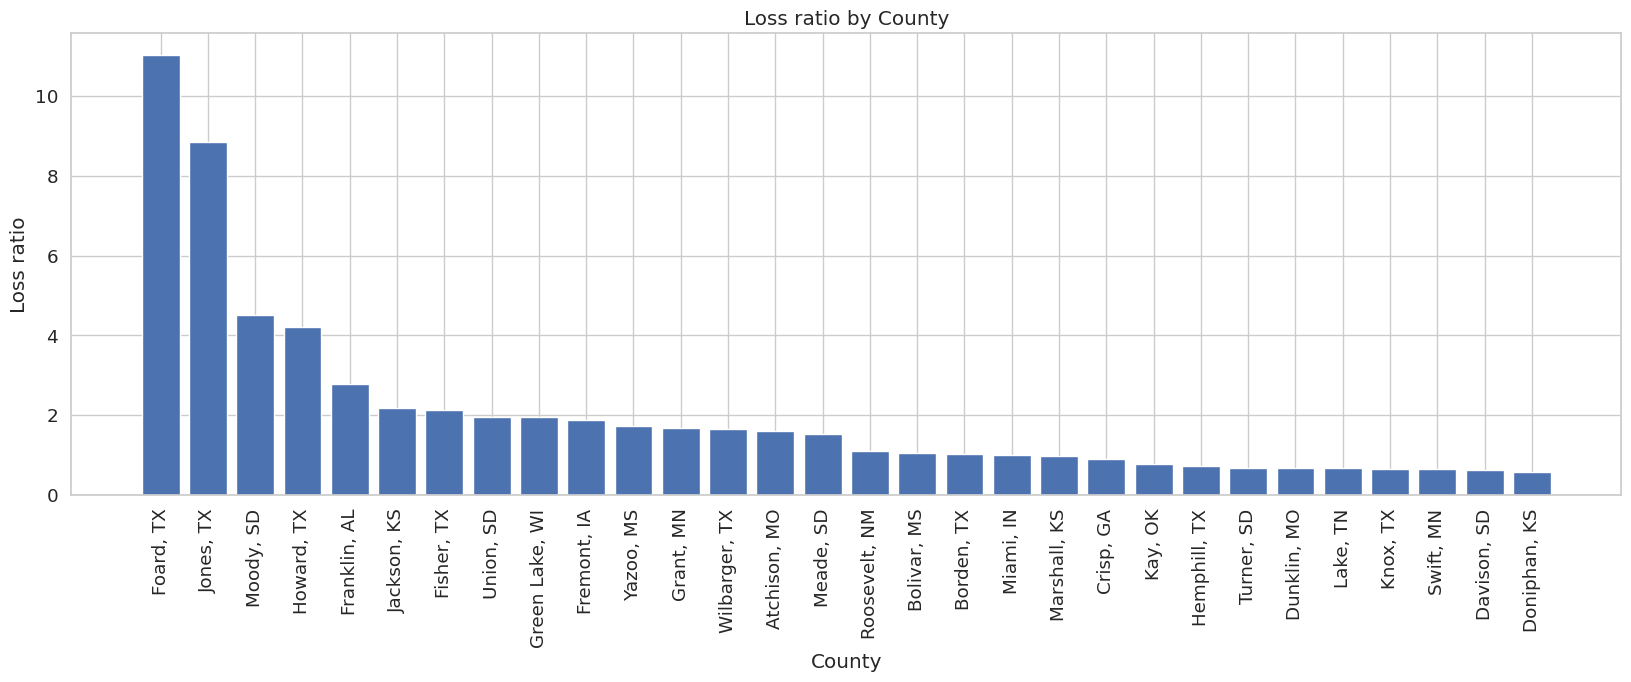

In [84]:
county_loss_ratio_df = county_loss_ratio_df.sort_values('loss_ratio', ascending = False)[:30]

plt.figure(figsize = (20, 6))

plt.bar(county_loss_ratio_df['County'], county_loss_ratio_df['loss_ratio'])

plt.title('Loss ratio by County')
plt.xlabel('County')
plt.ylabel('Loss ratio')

plt.xticks(rotation = 90)

plt.show()

#### **Discussion**: Determine if individual counties having high loss ratios are consistent, or if these loss ratios are due to natural disaster or one-time incidences.
#### It should be noted that it may be illegal to suggest underwriting changes based on counties.
#### It appears that Texas counties have the highest loss ratios.

#### **Hypothesis**: Look at counties with a high loss ratio over time to determine if its loss ratio is consistently high or if it is due to one-time events.

#### **Jones, TX**

In [85]:
jones_tx_claims_df = claims_df.loc[(claims_df['County'] == 'Jones') & (claims_df['State'] == 'TX')]

In [86]:
jones_tx_claims_df

,PolicyNumber,CustomerId,DateOfLoss,ClaimReceivedDate,ClaimCause,TotalPaidToDate,Deductible,County,State,EquipmentYear,PolicyEffectiveDate
1381,P-1757-2019,2644,2019-09-02,2019-09-04,M&E-Irr,32974.48,1000,Jones,TX,2002.0,2019-03-18
1560,P-1757-2019,2644,2019-07-07,2019-07-22,Lightning-Irr,12872.95,1000,Jones,TX,2002.0,2019-03-18


In [87]:
jones_tx_premiums_df = premiums_df.loc[(premiums_df['County'] == 'Jones') & (premiums_df['State'] == 'TX')]

In [88]:
jones_tx_premiums_df

,PolicyNumber,CustomerId,Loc,PolicyEffectiveDate,PolicyExpirationDate,PolicyPremium,LocationPremium,Deductible,LocValue,County,State,Equip Year,Equip Value
31224,P-1757-2018,2644,1,2018-03-18,2019-03-18,1672.0,836.0,1000,52228.0,Jones,TX,2002.0,52228.0
31225,P-1757-2019,2644,1,2019-03-18,2020-03-18,1672.0,836.0,1000,52228.0,Jones,TX,2002.0,52228.0
31226,P-1757-2020,2644,1,2020-03-18,2021-03-18,1838.0,919.0,1000,52228.0,Jones,TX,2002.0,52228.0


#### **Discussion**: In this case, the particular customer has a yearly policy for a single piece of equipment for 3 years.
#### The equipment was damaged twice in a 3 month period in 2019, leading to the high loss ratio.

### Loss ratio by number of previous claims
#### **Procedure**: Sum the claims amount per count of previous claims; sum then premiums per count of previous claims. Calculate the loss ratio.

In [89]:
premiums_agg_df = premiums_df[['CustomerId', 'PolicyPremium']].groupby('CustomerId').sum().reset_index()

In [90]:
customer_claim_count_df = claims_df.groupby('CustomerId').agg(
    count = ('CustomerId', 'count'),
    TotalPaidSum = ('TotalPaidToDate', 'sum')
).reset_index()

In [91]:
premium_customer_claims_agg_df = pd.merge(premiums_agg_df, customer_claim_count_df, on = 'CustomerId', how = 'left')

In [92]:
premium_customer_claims_agg_df['count'] = premium_customer_claims_agg_df['count'].fillna(0.0)
premium_customer_claims_agg_df['TotalPaidSum'] = premium_customer_claims_agg_df['TotalPaidSum'].fillna(0.0)

In [93]:
count_loss_ratio_df = premium_customer_claims_agg_df.groupby('count').agg(
    PolicyPremiumSum = ('PolicyPremium', 'sum'),
    TotalPaidSum = ('TotalPaidSum', 'sum')
).reset_index()

In [94]:
count_loss_ratio_df['loss_ratio'] = count_loss_ratio_df['TotalPaidSum'] / count_loss_ratio_df['PolicyPremiumSum']

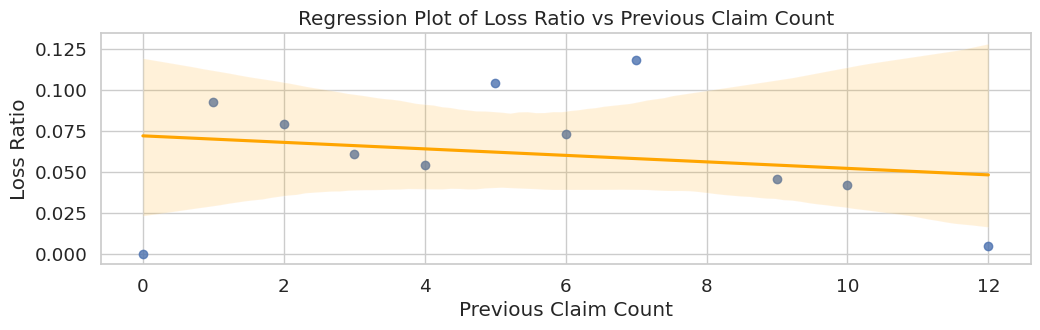

In [95]:
plt.figure(figsize = (12, 3))

sns.regplot(x = 'count', y = 'loss_ratio', data = count_loss_ratio_df, line_kws = {'color': 'orange'})

plt.title('Regression Plot of Loss Ratio vs Previous Claim Count')
plt.xlabel('Previous Claim Count')
plt.ylabel('Loss Ratio')

plt.show()

In [96]:
slope, intercept, r_value, p_value, std_err = stats.linregress(count_loss_ratio_df['count'], count_loss_ratio_df['loss_ratio'])
print('p-value:', p_value)

p-value: 0.5486811101305972


#### **Discussion**: The above regplot seems to suggest that there may be a negative correlation between previous claim count and loss ratio.
#### However, this is found to not be statistically significant with a high p-value of 0.549.

#### **Discussion**: This is a counter-intuitive results. This suggest that previous claim count should not be used as an indicator of an increased loss ratio.
#### Moreover, this result may be due to pre-existing business processes that increase premiums after each claim. We have insufficient data to test this hypothesis though.

### Loss ratio by deductible
#### **Procedure**: Sum the claims amount per deductible; sum then premiums per deductible. Calculate the loss ratio.

In [97]:
claims_agg_df = claims_combined_county_state_df[['Deductible', 'TotalPaidToDate']].groupby('Deductible').sum().reset_index()

In [98]:
premiums_agg_df = premiums_combined_county_state_df[['Deductible', 'PolicyPremium']].groupby('Deductible').sum().reset_index()

In [99]:
deductible_loss_ratio_df = pd.merge(claims_agg_df, premiums_agg_df, on = 'Deductible', how = 'inner')

In [100]:
deductible_loss_ratio_df['loss_ratio'] = deductible_loss_ratio_df['TotalPaidToDate'] / deductible_loss_ratio_df['PolicyPremium']

In [101]:
deductible_loss_ratio_df

,Deductible,TotalPaidToDate,PolicyPremium,loss_ratio
0,1000,51535843.08,7.334725e+08,0.070263
1,2500,7228892.85,2.367513e+08,0.030534
2,5000,2831641.98,2.182550e+08,0.012974
3,10000,2153277.14,7.844958e+07,0.027448
4,25000,114858.24,3.548026e+07,0.003237


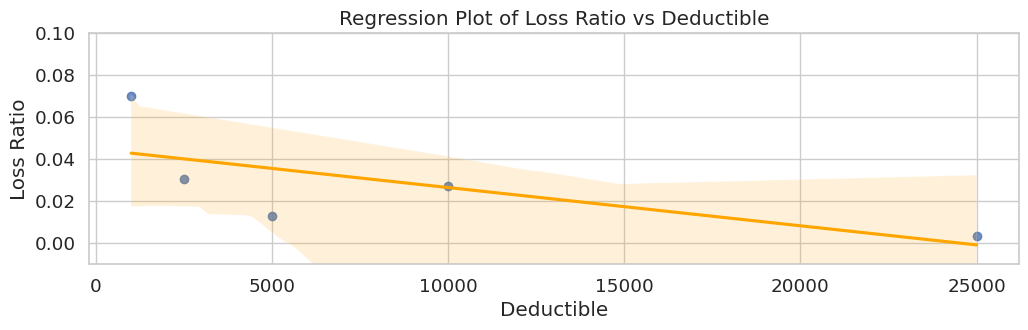

In [102]:
plt.figure(figsize = (12, 3))

sns.regplot(x = 'Deductible', y = 'loss_ratio', data = deductible_loss_ratio_df, line_kws = {'color': 'orange'})

plt.title('Regression Plot of Loss Ratio vs Deductible')
plt.xlabel('Deductible')
plt.ylabel('Loss Ratio')
plt.ylim([-0.01, 0.1])

plt.show()

In [103]:
slope, intercept, r_value, p_value, std_err = stats.linregress(deductible_loss_ratio_df['Deductible'], deductible_loss_ratio_df['loss_ratio'])
print('p-value:', p_value)

p-value: 0.19592535940528974


#### **Discussion**: The above plot suggests that deductible has a negative correlation with loss ratio.
#### This suggests that in underwriting practices, we can decrease the loss ratio by increasing the deductible.
#### This makes intuitive sense.
#### This may be our most powerful tool in decreasing our loss ratio.
#### A p-value of 0.196 suggests that we do not have enough info to come to a conclusion on if this correlation is statistically significant.

### Loss ratio by equip year
#### **Procedure**: Sum the claims amount per equip year; sum the premiums per equip year. Calculate the loss ratio.

In [104]:
claims_agg_df = claims_combined_county_state_df[['EquipmentYear', 'TotalPaidToDate']].groupby('EquipmentYear').sum().reset_index()

In [105]:
claims_agg_df = claims_agg_df.rename(columns = {
  'EquipmentYear': 'Equip Year'  
})

In [106]:
premiums_agg_df = premiums_combined_county_state_df[['Equip Year', 'PolicyPremium']].groupby('Equip Year').sum().reset_index()

In [107]:
equip_year_loss_ratio_df = pd.merge(claims_agg_df, premiums_agg_df, on = 'Equip Year', how = 'inner')

In [108]:
equip_year_loss_ratio_df['loss_ratio'] = equip_year_loss_ratio_df['TotalPaidToDate'] / equip_year_loss_ratio_df['PolicyPremium']

In [109]:
equip_year_loss_ratio_df = equip_year_loss_ratio_df.sort_values('Equip Year')

In [110]:
equip_year_loss_ratio_df_zeros = equip_year_loss_ratio_df.loc[equip_year_loss_ratio_df['Equip Year'] == 0.0].copy()
equip_year_loss_ratio_df = equip_year_loss_ratio_df.loc[equip_year_loss_ratio_df['Equip Year'] != 0.0]

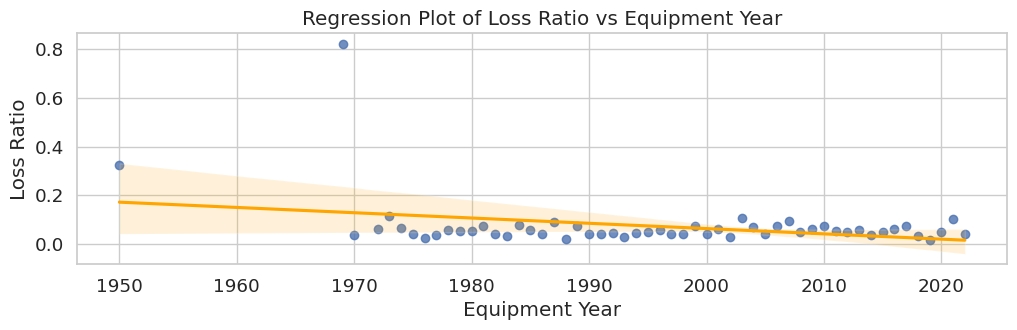

In [111]:
plt.figure(figsize = (12, 3))

sns.regplot(x = 'Equip Year', y = 'loss_ratio', data = equip_year_loss_ratio_df, line_kws = {'color': 'orange'})

plt.title('Regression Plot of Loss Ratio vs Equipment Year')
plt.xlabel('Equipment Year')
plt.ylabel('Loss Ratio')

plt.show()

In [112]:
equip_year_loss_ratio_df = equip_year_loss_ratio_df.loc[equip_year_loss_ratio_df['Equip Year'] > 1969]

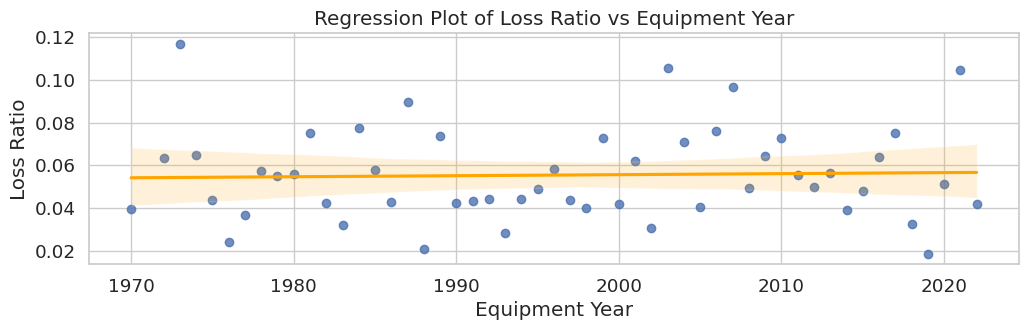

In [113]:
plt.figure(figsize = (12, 3))

sns.regplot(x = 'Equip Year', y = 'loss_ratio', data = equip_year_loss_ratio_df, line_kws = {'color': 'orange'})

plt.title('Regression Plot of Loss Ratio vs Equipment Year')
plt.xlabel('Equipment Year')
plt.ylabel('Loss Ratio')

plt.show()

In [114]:
slope, intercept, r_value, p_value, std_err = stats.linregress(equip_year_loss_ratio_df['Equip Year'], equip_year_loss_ratio_df['loss_ratio'])
print('p-value:', p_value)

p-value: 0.8109192218389215


#### **Discussion**: There appears to be no correlation between equipment year and loss ratio, suggesting that current underwriting policies properly account for the risks of ageing equipment.

## Multivariate Analysis (EDA):
### 1. Deductible, State, and Equipment Value
### 2. Premium, State, and Equipment Value

In [115]:
deductible_state_equip_value_df = premiums_df.copy()
deductible_state_equip_value_df['deductible_equip_val_ratio'] = deductible_state_equip_value_df['Deductible'] / deductible_state_equip_value_df['Equip Value']

In [116]:
state_avg_deductible_to_equip_ratio = deductible_state_equip_value_df.groupby('State')['deductible_equip_val_ratio'].mean().reset_index().sort_values('deductible_equip_val_ratio', ascending = False)

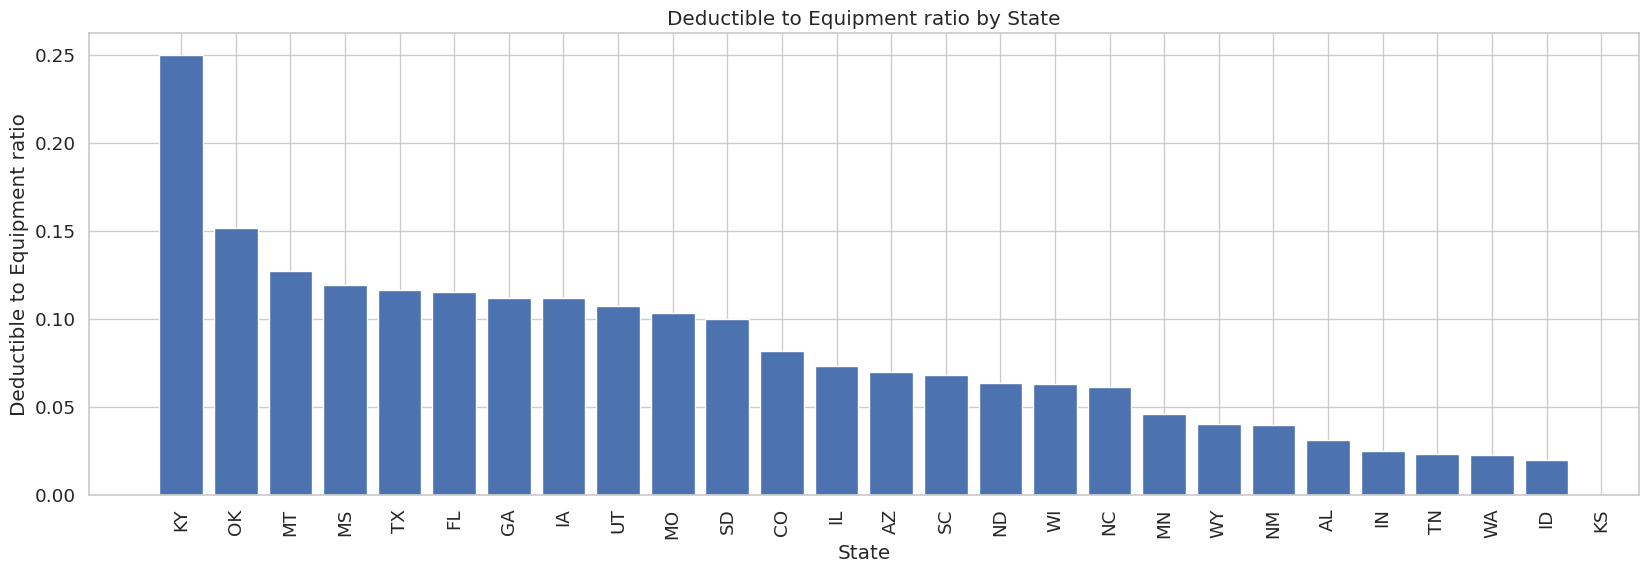

In [117]:
plt.figure(figsize = (20, 6))

plt.bar(state_avg_deductible_to_equip_ratio['State'], state_avg_deductible_to_equip_ratio['deductible_equip_val_ratio'])

plt.title('Deductible to Equipment ratio by State')
plt.xlabel('State')
plt.ylabel('Deductible to Equipment ratio')

plt.xticks(rotation = 90)

plt.show()

#### **Discussion**: Kentucky, Oklahoma, Montana, Misssissippi, and Texas are among the highest in terms of average deductible to equipment ratio
#### This suggests that customers in these regions are not receiving competitive insurance policies.

In [118]:
premium_state_equip_value_df = premiums_df.copy()
premium_state_equip_value_df['premium_equip_val_ratio'] = premium_state_equip_value_df['PolicyPremium'] / deductible_state_equip_value_df['Equip Value']

In [119]:
premium_state_equip_value_df = premium_state_equip_value_df.groupby('State')['premium_equip_val_ratio'].mean().reset_index().sort_values('premium_equip_val_ratio', ascending = False)

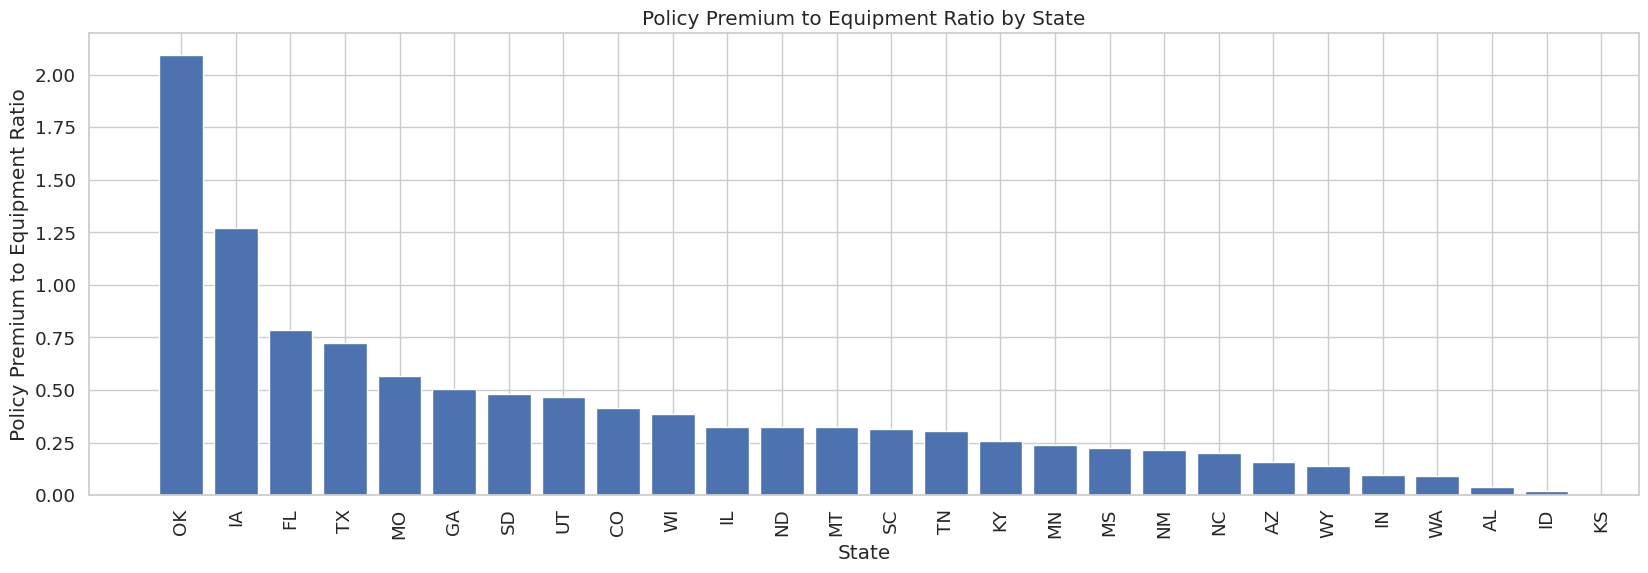

In [120]:
plt.figure(figsize = (20, 6))

plt.bar(premium_state_equip_value_df['State'], premium_state_equip_value_df['premium_equip_val_ratio'])

plt.title('Policy Premium to Equipment Ratio by State')
plt.xlabel('State')
plt.ylabel('Policy Premium to Equipment Ratio')

plt.xticks(rotation = 90)

plt.show()

#### **Discussion**: Oklahoma, Iowa, Florida, Texas, and Missouri are among the highest in terms of average policy premium to equipment ratio.
#### This suggests that customers in these regions are not receiving competitive insurance policies.

## Further Multivariate Analysis
### 1. Deductible, State, and Claim Value

In [121]:
premiums_agg_df = premiums_df[['Deductible', 'State']].groupby('State').sum()

In [122]:
claim_agg_df = claims_df[['TotalPaidToDate', 'State']].groupby('State').sum()

In [123]:
premiums_claims_agg_df = pd.merge(premiums_agg_df, claim_agg_df, on = 'State', how = 'inner').reset_index()

In [124]:
premiums_claims_agg_df['deductible_to_claim_ratio'] = premiums_claims_agg_df['Deductible'] / premiums_claims_agg_df['TotalPaidToDate']

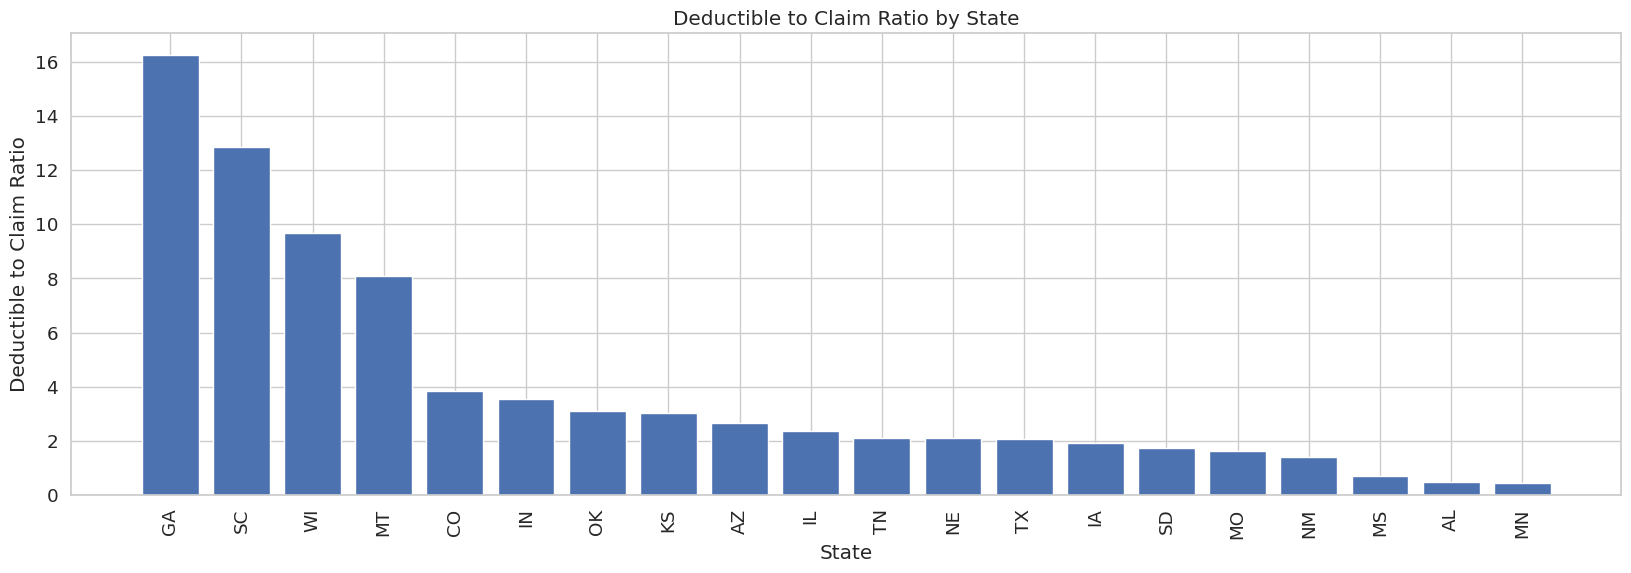

In [125]:
premiums_claims_agg_df = premiums_claims_agg_df.sort_values('deductible_to_claim_ratio', ascending = False)

plt.figure(figsize = (20, 6))

plt.bar(premiums_claims_agg_df['State'], premiums_claims_agg_df['deductible_to_claim_ratio'])

plt.title('Deductible to Claim Ratio by State')
plt.xlabel('State')
plt.ylabel('Deductible to Claim Ratio')

plt.xticks(rotation = 90)

plt.show()

# Loss Ratio Trend Analysis

In [126]:
claims_df['ClaimReceivedDate'].describe()

count                             2219
mean     2020-06-09 13:35:04.191076864
min                2018-01-15 00:00:00
25%                2019-04-18 12:00:00
50%                2020-06-08 00:00:00
75%                2021-09-13 12:00:00
max                2023-03-09 00:00:00
Name: ClaimReceivedDate, dtype: object

In [127]:
premiums_df['PolicyEffectiveDate'].describe()

count                            79754
mean     2020-04-28 23:10:45.755698432
min                2017-08-01 00:00:00
25%                2019-02-01 00:00:00
50%                2020-04-01 00:00:00
75%                2021-07-03 00:00:00
max                2023-03-31 00:00:00
Name: PolicyEffectiveDate, dtype: object

In [128]:
claim_paid_by_date_df = claims_df.groupby('ClaimReceivedDate')['TotalPaidToDate'].sum().reset_index().sort_values('ClaimReceivedDate')
claim_paid_by_date_df.set_index('ClaimReceivedDate', inplace = True)
idx = pd.date_range(start = '2017-08-01', end = '2023-03-31')

claim_paid_by_date_df = claim_paid_by_date_df.reindex(idx)
claim_paid_by_date_df['TotalPaidToDate'].fillna(0.0, inplace = True)

In [129]:
claim_paid_by_date_df.head(5)

,TotalPaidToDate
2017-08-01,0.0
2017-08-02,0.0
2017-08-03,0.0
2017-08-04,0.0
2017-08-05,0.0


In [130]:
premium_paid_by_date_df = premiums_df.groupby('PolicyEffectiveDate')['PolicyPremium'].sum().reset_index().sort_values('PolicyEffectiveDate')
premium_paid_by_date_df.set_index('PolicyEffectiveDate', inplace = True)
idx = pd.date_range(start = '2017-08-01', end = '2023-03-31')

premium_paid_by_date_df = premium_paid_by_date_df.reindex(idx)
premium_paid_by_date_df['PolicyPremium'].fillna(0.0, inplace = True)

In [131]:
premium_paid_by_date_df.head(5)

,PolicyPremium
2017-08-01,522227.000851
2017-08-02,0.000000
2017-08-03,0.000000
2017-08-04,0.000000
2017-08-05,0.000000


In [132]:
claim_paid_by_date_df['cumulative_claims'] = claim_paid_by_date_df['TotalPaidToDate'].cumsum()
premium_paid_by_date_df['cumulative_premiums'] = premium_paid_by_date_df['PolicyPremium'].cumsum()

In [133]:
claim_paid_by_date_df = claim_paid_by_date_df.reset_index()
premium_paid_by_date_df = premium_paid_by_date_df.reset_index()

In [134]:
claim_paid_by_date_df = claim_paid_by_date_df.rename(columns = {'index': 'date'})
premium_paid_by_date_df = premium_paid_by_date_df.rename(columns = {'index': 'date'})

In [135]:
loss_ratio_by_date_df = pd.merge(claim_paid_by_date_df, premium_paid_by_date_df, on = 'date', how = 'inner')

In [136]:
loss_ratio_by_date_df['daily_loss_ratio'] = loss_ratio_by_date_df['cumulative_claims'] / loss_ratio_by_date_df['cumulative_premiums']

In [137]:
loss_ratio_by_date_df.head(5)

,date,TotalPaidToDate,cumulative_claims,PolicyPremium,cumulative_premiums,daily_loss_ratio
0,2017-08-01,0.0,0.0,522227.000851,522227.000851,0.0
1,2017-08-02,0.0,0.0,0.000000,522227.000851,0.0
2,2017-08-03,0.0,0.0,0.000000,522227.000851,0.0
3,2017-08-04,0.0,0.0,0.000000,522227.000851,0.0
4,2017-08-05,0.0,0.0,0.000000,522227.000851,0.0


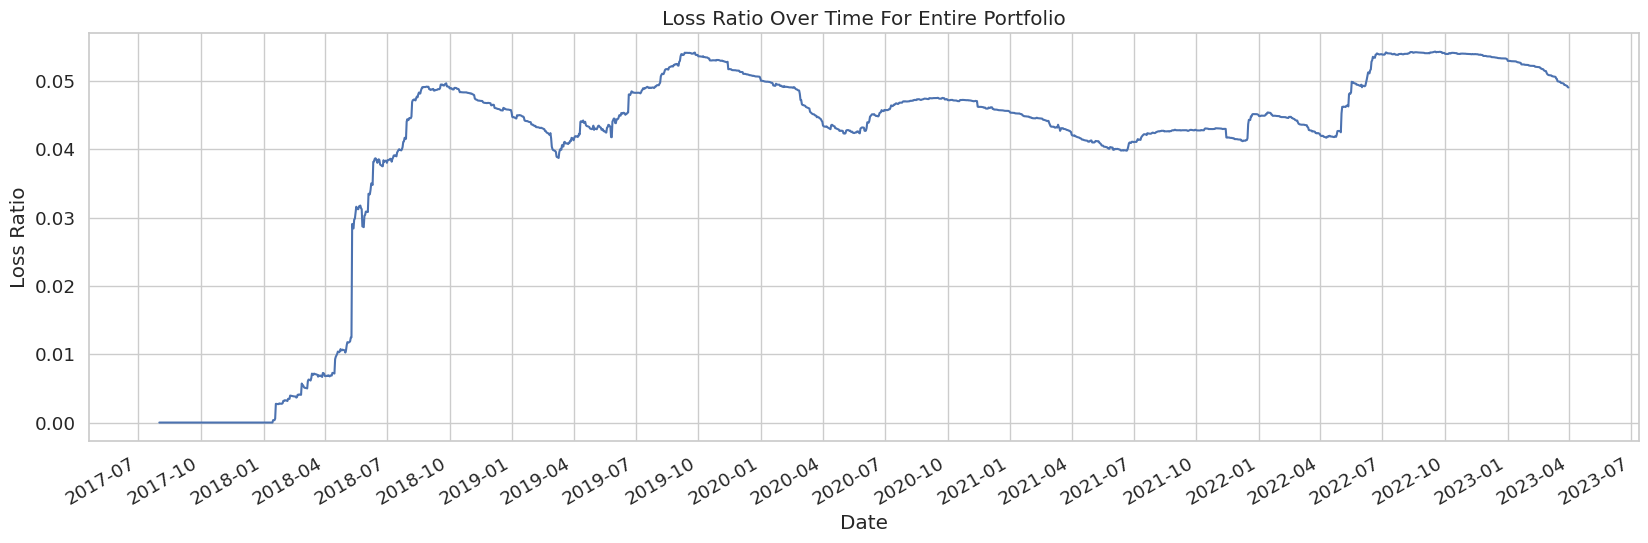

In [138]:
fig, ax = plt.subplots(figsize=(20, 6))

ax.plot(loss_ratio_by_date_df['date'], loss_ratio_by_date_df['daily_loss_ratio'])

ax.xaxis.set_major_locator(mdates.MonthLocator(interval = 3))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

ax.set_title('Loss Ratio Over Time For Entire Portfolio')
ax.set_xlabel('Date')
ax.set_ylabel('Loss Ratio')

fig.autofmt_xdate()

plt.show()

#### **Discussion**: This graphs suggests that our portfolio remains at approximately a 0.05 loss ratio for the past 5 years.
#### Moreover, we have seasons in the winter where loss ratios grow the highest (~0.06).

In [139]:
loss_ratio_by_date_df.set_index('date', inplace = True)
loss_ratio_by_date_df['180d_rolling_claims'] = loss_ratio_by_date_df['TotalPaidToDate'].rolling('180D').sum()
loss_ratio_by_date_df['180d_rolling_premium'] = loss_ratio_by_date_df['PolicyPremium'].rolling('180D').sum()

In [140]:
loss_ratio_by_date_df['180d_rolling_loss_ratio'] = loss_ratio_by_date_df['180d_rolling_claims'] / loss_ratio_by_date_df['180d_rolling_premium']

In [141]:
loss_ratio_by_date_df = loss_ratio_by_date_df.reset_index()

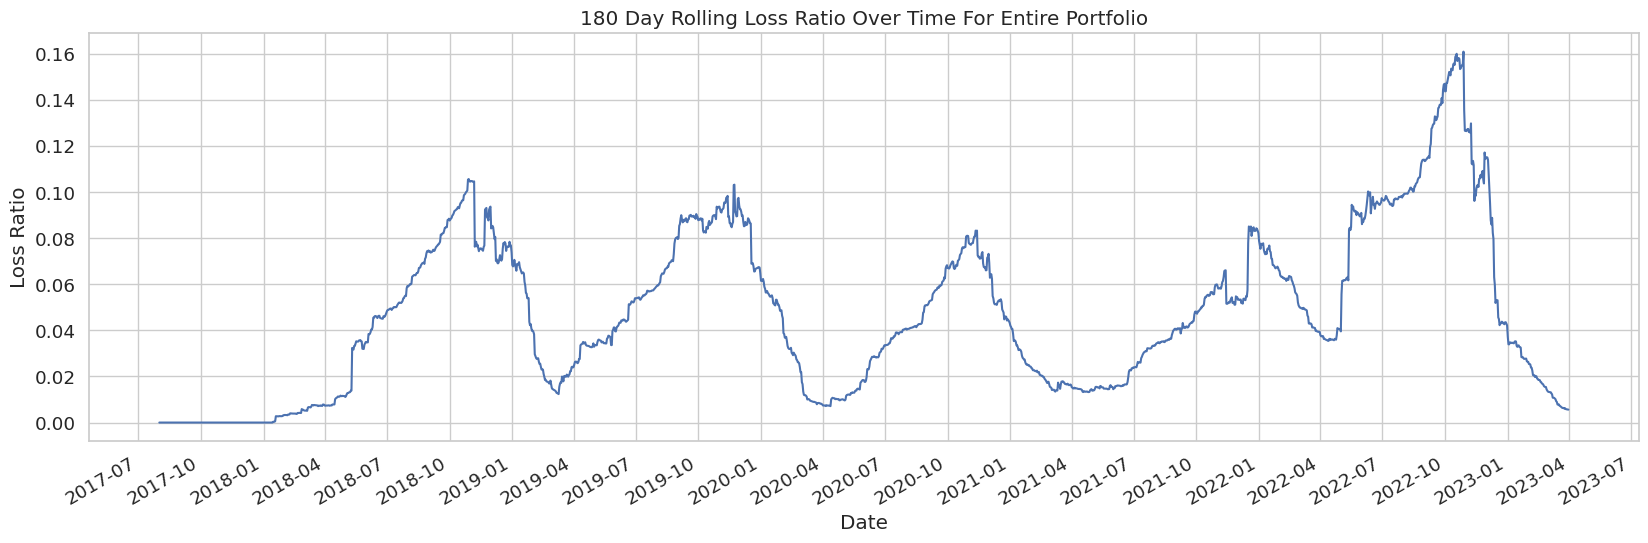

In [142]:
fig, ax = plt.subplots(figsize=(20, 6))

ax.plot(loss_ratio_by_date_df['date'], loss_ratio_by_date_df['180d_rolling_loss_ratio'])

ax.xaxis.set_major_locator(mdates.MonthLocator(interval = 3))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

ax.set_title('180 Day Rolling Loss Ratio Over Time For Entire Portfolio')
ax.set_xlabel('Date')
ax.set_ylabel('Loss Ratio')

fig.autofmt_xdate()

plt.show()

#### **Discussion:** 180 day rolling loss ratios peak in December.

In [143]:
loss_ratio_by_date_df.set_index('date', inplace = True)
loss_ratio_by_date_df['90d_rolling_claims'] = loss_ratio_by_date_df['TotalPaidToDate'].rolling('90D').sum()
loss_ratio_by_date_df['90d_rolling_premium'] = loss_ratio_by_date_df['PolicyPremium'].rolling('90D').sum()

In [144]:
loss_ratio_by_date_df['90d_rolling_loss_ratio'] = loss_ratio_by_date_df['90d_rolling_claims'] / loss_ratio_by_date_df['90d_rolling_premium']

In [145]:
loss_ratio_by_date_df = loss_ratio_by_date_df.reset_index()

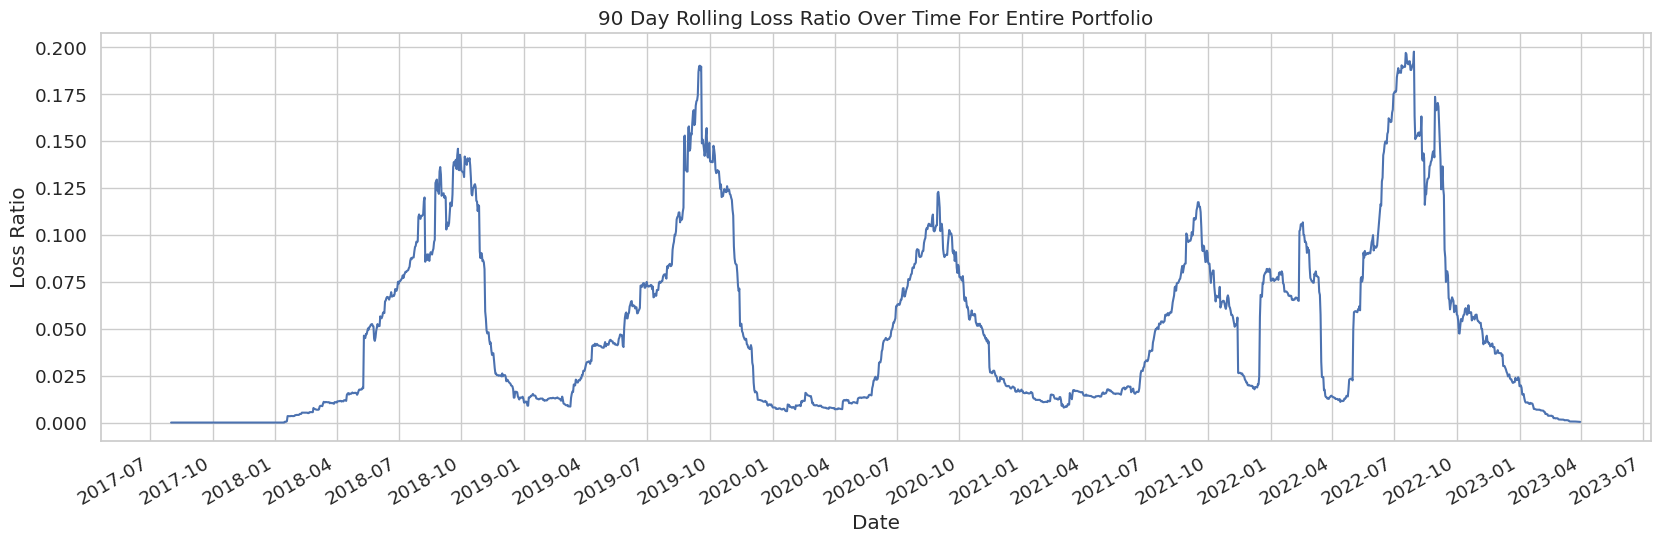

In [146]:
fig, ax = plt.subplots(figsize=(20, 6))

ax.plot(loss_ratio_by_date_df['date'], loss_ratio_by_date_df['90d_rolling_loss_ratio'])

ax.xaxis.set_major_locator(mdates.MonthLocator(interval = 3))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

ax.set_title('90 Day Rolling Loss Ratio Over Time For Entire Portfolio')
ax.set_xlabel('Date')
ax.set_ylabel('Loss Ratio')

fig.autofmt_xdate()

plt.show()

#### **Discussion:**: Loss ratios in the winter represent a degree of risk for Fortegra. We may want to consider mitigating losses due to claims made in the winter.
1. Risk-based Pricing: Insurance premiums are calculated based on risk assessment. If certain risks are more prevalent in winter months (e.g., home heating issues, car accidents due to icy roads), insurance companies can factor these into their pricing models, charging more for policies covering these risks to offset the higher likelihood of claims.
2. 
Seasonal Coverage Options: Insurance companies can offer seasonal coverage options or add-ons that provide extra coverage for specific events during the winter months. This can lead to additional premium income that helps offset the higher number of claims.

## Curve Fitting the 90 Day Rolling Loss Ratio

In [147]:
x = loss_ratio_by_date_df['date'].values.astype('datetime64[D]').view('int64')
y = loss_ratio_by_date_df['90d_rolling_loss_ratio'].copy().values.flatten()

In [148]:
def func(x, a, b, c, d):
    return a * np.sin(b * x + c) + d

In [149]:
p0 = (0.08, 0.018, -200, 0.1)
popt, pcov = curve_fit(func, x, y, p0, maxfev = 10000)

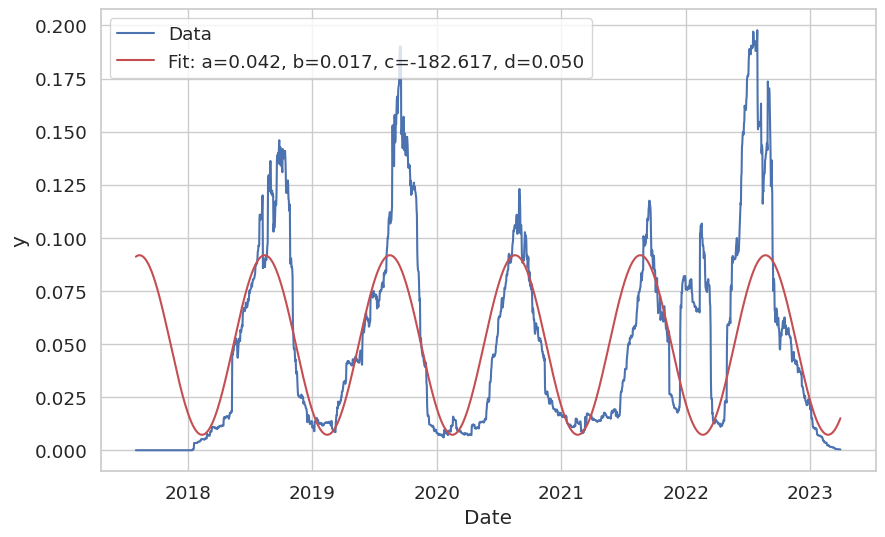

In [150]:
plt.figure(figsize = (10, 6))
plt.plot(loss_ratio_by_date_df['date'], y, label = 'Data')
plt.plot(loss_ratio_by_date_df['date'], func(x, *popt), 'r-', label='Fit: a=%5.3f, b=%5.3f, c=%5.3f, d=%5.3f' % tuple(popt))
plt.xlabel('Date')
plt.ylabel('y')
plt.legend()
plt.show()

#### **Discussion**: The above loss ratio trend is seasonal and can be modeled by:
#### 90 day rolling loss ratio = 0.042 * np.sin(0.017 * x + -182.617) + 0.05
#### for ordinal time.

## Profitability Analysis Over Time
### Net Profit is what Fortegra technically wants; minimizing loss ratio is one factor in achieving this goal.

In [151]:
loss_ratio_by_date_df['profitability_over_time'] = loss_ratio_by_date_df['cumulative_premiums'] - loss_ratio_by_date_df['cumulative_claims']

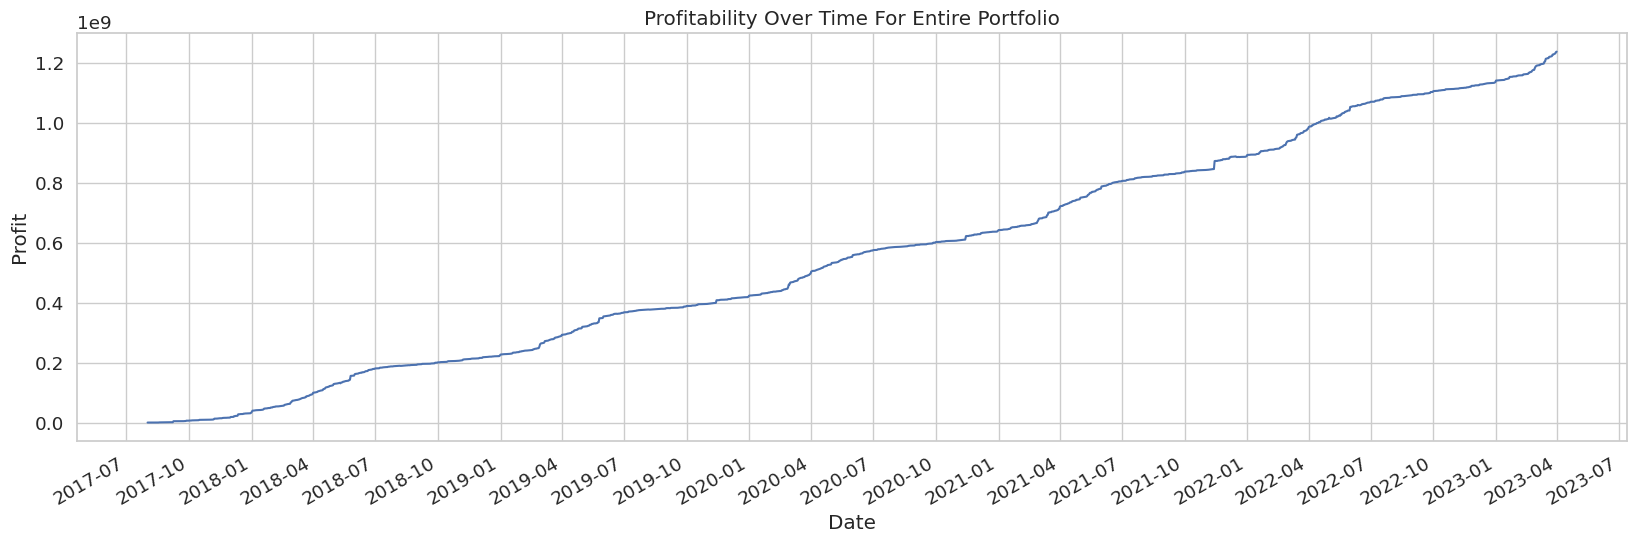

In [152]:
fig, ax = plt.subplots(figsize = (20, 6))

ax.plot(loss_ratio_by_date_df['date'], loss_ratio_by_date_df['profitability_over_time'])

ax.xaxis.set_major_locator(mdates.MonthLocator(interval = 3))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

ax.set_title('Profitability Over Time For Entire Portfolio')
ax.set_xlabel('Date')
ax.set_ylabel('Profit')

fig.autofmt_xdate()

plt.show()

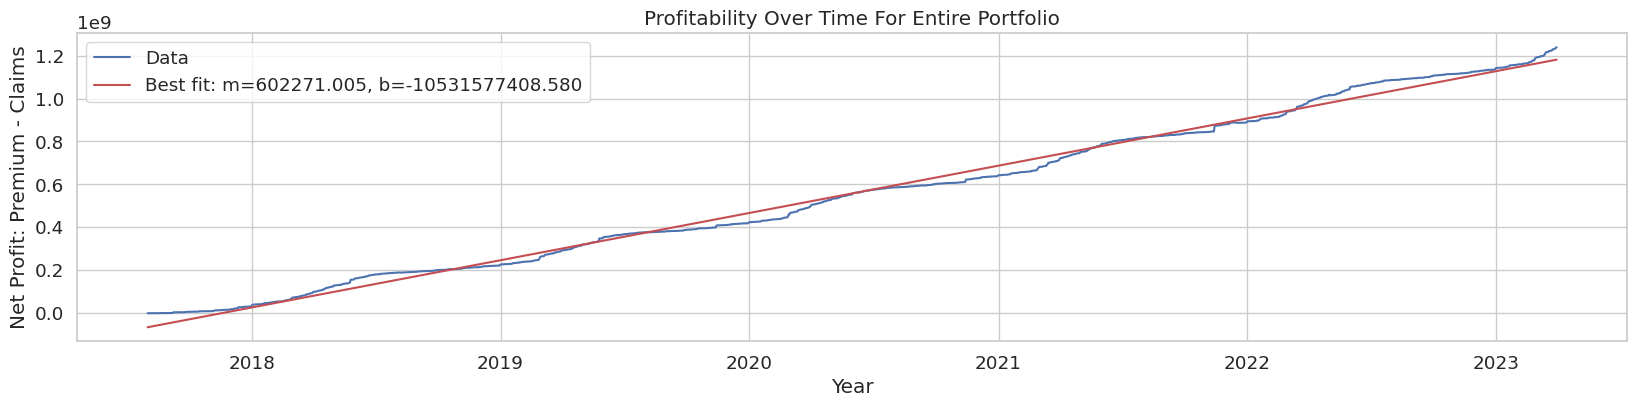

In [153]:
x = loss_ratio_by_date_df['date'].values.astype('datetime64[D]').view('int64')
y = loss_ratio_by_date_df['profitability_over_time'].copy().values.flatten()

parameters = np.polyfit(x, y, 1)

y_fit = parameters[0] * x + parameters[1]

plt.figure(figsize = (20, 4))
plt.plot(loss_ratio_by_date_df['date'].values, y, label = 'Data')
plt.plot(x, y_fit, 'r-', label = 'Best fit: m=%5.3f, b=%5.3f' % (parameters[0], parameters[1]))

plt.title('Profitability Over Time For Entire Portfolio')
plt.xlabel('Year')
plt.ylabel('Net Profit: Premium - Claims')
plt.legend()
plt.show()

#### **Discussion**: According to the line of best fit, the portfolio is profitting linearly at a rate of $600,000/day.
#### A linear rate of profit implies that the customer base is remaining stagnant and the loss ratio is relatively unchanging; loss ratio = 0.05 (as seen in a previous analysis).

## Customer Retention and Growth Analysis

### Customer Growth

In [154]:
customer_retention_df = premiums_df.groupby('CustomerId').agg({
    'PolicyEffectiveDate': 'min',
    'PolicyExpirationDate': 'max'
}).reset_index().rename(columns = {
    'PolicyEffectiveDate': 'EarliestPolicyEffectiveDate',
    'PolicyExpirationDate': 'LatestPolicyExpirationDate'
})

In [155]:
add_customer_df = customer_retention_df \
    .sort_values('EarliestPolicyEffectiveDate', ascending = True) \
    .groupby('EarliestPolicyEffectiveDate')['CustomerId'].count().reset_index() \
    .rename(columns = {'EarliestPolicyEffectiveDate': 'Date', 'CustomerId': 'Customer_Add_Count'})

In [156]:
drop_customer_df = customer_retention_df \
    .sort_values('LatestPolicyExpirationDate', ascending = True) \
    .groupby('LatestPolicyExpirationDate')['CustomerId'].count().reset_index() \
    .rename(columns = {'LatestPolicyExpirationDate': 'Date', 'CustomerId': 'Customer_Drop_Count'})

In [157]:
add_customer_df.head(2)

,Date,Customer_Add_Count
0,2017-08-01,2
1,2017-08-09,1


In [158]:
drop_customer_df.head(2)

,Date,Customer_Drop_Count
0,2018-08-21,1
1,2018-08-22,1


In [159]:
start_date = '2017-08-01'
end_date = '2024-03-31'

dates = pd.date_range(start = start_date, end = end_date)

customer_tally_df = pd.DataFrame(dates, columns = ['Date'])

In [160]:
customer_tally_df = pd.merge(customer_tally_df, add_customer_df, on = 'Date', how = 'left')

In [161]:
customer_tally_df = pd.merge(customer_tally_df, drop_customer_df, on = 'Date', how = 'left')

In [162]:
customer_tally_df = customer_tally_df.fillna(0.0)

In [163]:
customer_tally_df['Customers_Added'] = customer_tally_df['Customer_Add_Count'].cumsum()
customer_tally_df['Customers_Dropped'] = customer_tally_df['Customer_Drop_Count'].cumsum()

In [164]:
customer_tally_df['TotalCustomerCount'] = customer_tally_df['Customers_Added'] - customer_tally_df['Customers_Dropped']

In [165]:
customer_tally_df = customer_tally_df.loc[customer_tally_df['Date'] <= '2023-01-01']

In [166]:
customer_tally_df

,Date,Customer_Add_Count,Customer_Drop_Count,Customers_Added,Customers_Dropped,TotalCustomerCount
0,2017-08-01,2.0,0.0,2.0,0.0,2.0
1,2017-08-02,0.0,0.0,2.0,0.0,2.0
2,2017-08-03,0.0,0.0,2.0,0.0,2.0
3,2017-08-04,0.0,0.0,2.0,0.0,2.0
4,2017-08-05,0.0,0.0,2.0,0.0,2.0
...,...,...,...,...,...,...
1975,2022-12-28,0.0,0.0,5243.0,2597.0,2646.0
1976,2022-12-29,1.0,0.0,5244.0,2597.0,2647.0
1977,2022-12-30,0.0,1.0,5244.0,2598.0,2646.0
1978,2022-12-31,1.0,0.0,5245.0,2598.0,2647.0


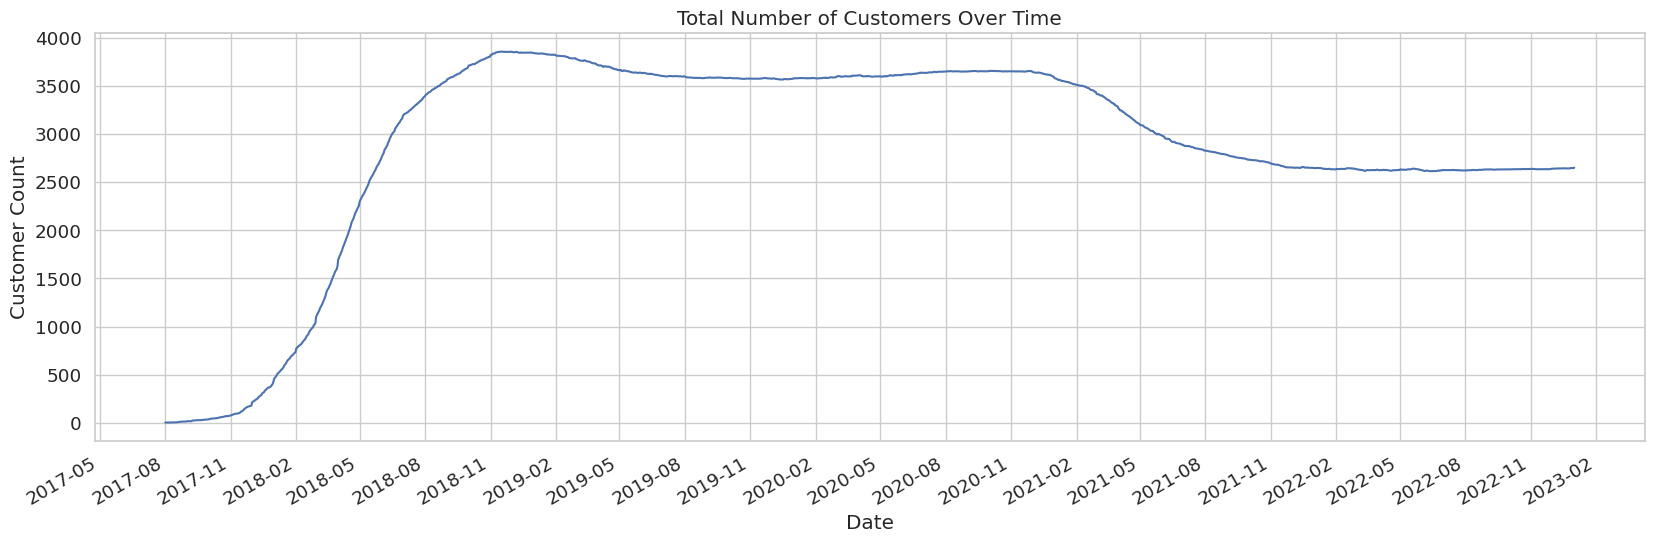

In [167]:
fig, ax = plt.subplots(figsize = (20, 6))

ax.plot(customer_tally_df['Date'], customer_tally_df['TotalCustomerCount'])

ax.xaxis.set_major_locator(mdates.MonthLocator(interval = 3))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

ax.set_title('Total Number of Customers Over Time')
ax.set_xlabel('Date')
ax.set_ylabel('Customer Count')

fig.autofmt_xdate()

plt.show()

#### **Discussion:** The customer count suddenly dropped in the first half of 2021.
#### This suggests there was some kind of underwriting change resulting in the loss.
#### Additionally, this shows why profitability of the portfolio remained stagnant (linear uptrend in gross profit over time) because
#### the loss ratio for the entire portfolio stayed the same while the customer base remained the same as well.
#### **Further Discussion:** This gives further credence to the idea that the customer base should be increased by increasing the loss ratio from underwriting.
#### This will give new potential customers a better bargain on their insurance and incentivize them to get a policy.

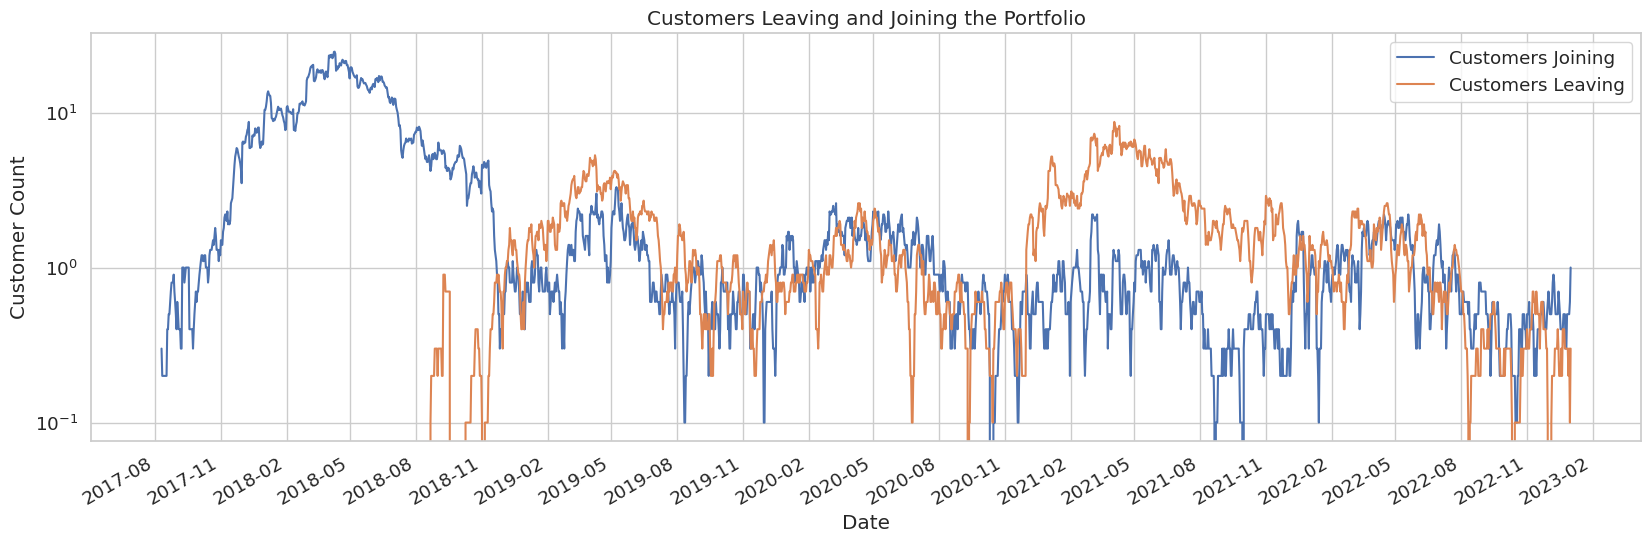

In [168]:
fig, ax = plt.subplots(figsize = (20, 6))

ax.plot(customer_tally_df['Date'], customer_tally_df['Customer_Add_Count'].rolling(10).mean(), label = 'Customers Joining')
ax.set_yscale('log')

ax.plot(customer_tally_df['Date'], customer_tally_df['Customer_Drop_Count'].rolling(10).mean(), label = 'Customers Leaving')
ax.set_yscale('log')

ax.xaxis.set_major_locator(mdates.MonthLocator(interval = 3))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

ax.set_title('Customers Leaving and Joining the Portfolio')
ax.set_xlabel('Date')
ax.set_ylabel('Customer Count')

fig.autofmt_xdate()

ax.legend()

plt.show()

#### **Discussion:** This graph suggests that there was a period of time between January 2021 through January 2022
#### where the number of customers leaving exceeded the number of customers joining. This suggested a policy change,
#### and as customer policies expired over the course of a year, the customers chose not to renew.

# Summary of Suggested Underwriting Changes and Insights

## **Suggestion 1:** Reduce the deductible in Texas - this will increase our loss ratio, BUT it will allow us to break into the Texas equipment market (which evidence suggest is 6 times larger than our current exposure). The deductible was shown to be one of the strongest contributors to loss ratio; a lower deductible would incentivize Texas customers to do business with us.
## **Suggestion 2:** Reduce our premium in Texas. Our deductible to claim ratio is already quite low, suggesting there is no room to reduce it even more.
## **Insight 3:** The current process for evaluating the underwriting given equipment year is successful and results in no discernable difference in the loss ratios.

## **Insight 4:** Increased deductibles seem to loosely correlate with lower loss ratios.

## **Insight 5:** The previous number of claims for a given customer do not seem to effect the loss ratio; this suggests our current underwriting process is sufficient as assessing the risk of multiple past claims.

## **Insight 6:** Counties with high average loss ratios havr these loss ratios due to outlier events. These events should not be treated as a reason to increase policy premiums or deductibles.

## **Insight 7:** States with high loss ratios have few policies and claims associated to them, so they should be treated as outliers.

## **Insight 8:** Equipment and policy premiums show a bi-model distribution, suggesting there are two distinct types of farm equipment (one more expensive than the other) represented in the dataset.

## **Insight 9:** Winter exposes Fortegra to slightly higher upside risk in loss ratios. This suggests that claims are seasonal, with peaks in the winter.

## **Suggestion 10:** Provide seasonal add-ons to coverage to mitigate upside risk in our portfolio in the winter.

## **Suggestion 11:** Increase premiums on equipment which are more likely to be damaged in the winter.

## **Insight 12:** Seasonality of loss ratio can be modeled as:
## 90 day rolling loss ratio = 0.042 * np.sin(0.017 * x + -182.617) + 0.05

## **Insight 13:** According to the line of best fit, the portfolio is growing in profit linearly at a rate of \$600,000/day.

## This implies that the yearly profit from this portfolio is $190 million.

## **Suggestion 14:** An underwriting change may have been made in early-2021 which preceded a mass exodus of customers. Maybe this underwriting change should be undone.

## **Suggestion 15:** Increase the loss ratio of our underwriting such that more customers would be incentivized to join the portfolio. This also supports the suggestions to expand into Texas, which has a larger opportunity for growth.

## **Insight 16:** The customer count for the portfolio has remained stagnant at around 3,000 since late-2018.

## **Suggestion 17:** A customer churn model should be created which predicts if a customer will fail to reinstate their policy. Those customers should be targeted for reduced premiums to improve retention.

## **Suggestion 18:** A claim prediction model should be created. If the model indicates that a customer is likely to make a future claim, we can choose to raise the premium for that customer; either way, it would be nice to know.